In [3]:
# Run this cell to import pyspark and to define start_spark() and stop_spark()

import findspark

findspark.init()

import getpass
import pandas as pd
import pyspark
import random
import re

from IPython.display import display, HTML
from pyspark import SparkContext
from pyspark.sql import SparkSession


# Functions used below

def username():
    """Get username with any domain information removed.
    """

    return re.sub('@.*', '', getpass.getuser())


def dict_to_html(d):
    """Convert a Python dictionary into a two column table for display.
    """

    html = []

    html.append(f'<table width="100%" style="width:100%; font-family: monospace;">')
    for k, v in d.items():
        html.append(f'<tr><td style="text-align:left;">{k}</td><td>{v}</td></tr>')
    html.append(f'</table>')

    return ''.join(html)


def show_as_html(df, n=10):
    """Leverage existing pandas jupyter integration to show a spark dataframe as html.
    
    Args:
        n (int): number of rows to show (default: 20)
    """

    display(df.limit(n).toPandas())

    
def display_spark():
    """Display the status of the active Spark session if one is currently running.
    """
    
    if 'spark' in globals() and 'sc' in globals():

        name = sc.getConf().get("spark.app.name")
        
        html = [
            f'<p><b>Spark</b></p>',
            f'<p>The spark session is <b><span style="color:green">active</span></b>, look for <code>{name}</code> under the running applications section in the Spark UI.</p>',
            f'<ul>',
            f'<li><a href="http://mathmadslinux2p.canterbury.ac.nz:8080/" target="_blank">Spark UI</a></li>',
            f'<li><a href="{sc.uiWebUrl}" target="_blank">Spark Application UI</a></li>',
            f'</ul>',
            f'<p><b>Config</b></p>',
            dict_to_html(dict(sc.getConf().getAll())),
            f'<p><b>Notes</b></p>',
            f'<ul>',
            f'<li>The spark session <code>spark</code> and spark context <code>sc</code> global variables have been defined by <code>start_spark()</code>.</li>',
            f'<li>Please run <code>stop_spark()</code> before closing the notebook or restarting the kernel or kill <code>{name}</code> by hand using the link in the Spark UI.</li>',
            f'</ul>',
        ]
        display(HTML(''.join(html)))
        
    else:
        
        html = [
            f'<p><b>Spark</b></p>',
            f'<p>The spark session is <b><span style="color:red">stopped</span></b>, confirm that <code>{username() + " (jupyter)"}</code> is under the completed applications section in the Spark UI.</p>',
            f'<ul>',
            f'<li><a href="http://mathmadslinux2p.canterbury.ac.nz:8080/" target="_blank">Spark UI</a></li>',
            f'</ul>',
        ]
        display(HTML(''.join(html)))


# Functions to start and stop spark

def start_spark(executor_instances=2, executor_cores=1, worker_memory=1, master_memory=1):
    """Start a new Spark session and define globals for SparkSession (spark) and SparkContext (sc).
    
    Args:
        executor_instances (int): number of executors (default: 2)
        executor_cores (int): number of cores per executor (default: 1)
        worker_memory (float): worker memory (default: 1)
        master_memory (float): master memory (default: 1)
    """

    global spark
    global sc

    user = username()
    
    cores = executor_instances * executor_cores
    partitions = cores * 4
    port = 4000 + random.randint(1, 999)

    spark = (
        SparkSession.builder
        .master("spark://masternode2:7077")
        .config("spark.driver.extraJavaOptions", f"-Dderby.system.home=/tmp/{user}/spark/")
        .config("spark.dynamicAllocation.enabled", "false")
        .config("spark.executor.instances", str(executor_instances))
        .config("spark.executor.cores", str(executor_cores))
        .config("spark.cores.max", str(cores))
        .config("spark.executor.memory", f"{worker_memory}g")
        .config("spark.driver.memory", f"{master_memory}g")
        .config("spark.driver.maxResultSize", "0")
        .config("spark.sql.shuffle.partitions", str(partitions))
        .config("spark.ui.port", str(port))
        .appName(user + " (jupyter)")
        .getOrCreate()
    )
    sc = SparkContext.getOrCreate()
    
    display_spark()

    
def stop_spark():
    """Stop the active Spark session and delete globals for SparkSession (spark) and SparkContext (sc).
    """

    global spark
    global sc

    if 'spark' in globals() and 'sc' in globals():

        spark.stop()

        del spark
        del sc

    display_spark()


# Make css changes to improve spark output readability

html = [
    '<style>',
    'pre { white-space: pre !important; }',
    'table.dataframe td { white-space: nowrap !important; }',
    'table.dataframe thead th:first-child, table.dataframe tbody th { display: none; }',
    '</style>',
]
display(HTML(''.join(html)))

In [4]:
# Helper functions

def show_class_balance(data, name="data", labelCol="label"):
    """Helper function to show class balance based on label.
    
    Note that this function does not return anything.

    Args:
        data (pyspark.sql.DataFrame): datafame with label
        name (str): name to print above metrics for readability 
        labelCol (str): label column name
    """

    total = data.count()
    counts = data.groupBy(labelCol).count().toPandas()
    counts["ratio"] = counts["count"] / total

    print(f'Class balance [{name}]')
    print(f'')
    print(f'total:   {total}')
    print(f'counts:')
    print(counts)
    print(f'')

def with_custom_prediction(
    pred,
    threshold,
    probabilityCol="probability",
    customPredictionCol="customPrediction",
):
    """Helper function to select a custom prediction column for a custom classification threshold.
    
    Args:
        pred (pyspark.sql.DataFrame): datafame with column for probability 
        threshold (float): classification threshold
        probabilityCol (str): probability column name
        customPredictionCol (str): new custom prediction column name
    
    Returns:
        pred (pyspark.sql.DataFrame): dataframe with new colum for custom prediction
    """

    classification_udf = F.udf(lambda x: int(x[1] > threshold), IntegerType())
    
    return pred.withColumn(customPredictionCol, classification_udf(F.col(probabilityCol)))


def show_metrics(
    pred,
    name="data",
    threshold=0.5,
    labelCol="label",
    predictionCol="prediction",
    rawPredictionCol="rawPrediction",
    probabilityCol="probability",
):
    """Helper function to evaluate and show metrics based on a custom classification threshold.
    
    Note that this function does not return anything.
    
    Args:
        pred (pyspark.sql.DataFrame): datafame with column for probability 
        name (str): name to print above metrics for readability 
        threshold (float): classification threshold (default: 0.5)
        predictionCol (str): prediction column name
        rawPredictionCol (str): raw prediction column name
        probabilityCol (str): probability column name
    """

    if threshold != 0.5:

        predictionCol = "customPrediction"
        pred = with_custom_prediction(pred, threshold, probabilityCol=probabilityCol, customPredictionCol=predictionCol)

    total = pred.count()

    nP_actual = pred.filter((F.col(labelCol) == 1)).count()
    nN_actual = pred.filter((F.col(labelCol) == 0)).count()

    nP = pred.filter((F.col(predictionCol) == 1)).count()
    nN = pred.filter((F.col(predictionCol) == 0)).count()
    TP = pred.filter((F.col(predictionCol) == 1) & (F.col(labelCol) == 1)).count()
    FP = pred.filter((F.col(predictionCol) == 1) & (F.col(labelCol) == 0)).count()
    FN = pred.filter((F.col(predictionCol) == 0) & (F.col(labelCol) == 1)).count()
    TN = pred.filter((F.col(predictionCol) == 0) & (F.col(labelCol) == 0)).count()

    if TP + FP > 0:
        precision = TP / (TP + FP)
    else:
        precision = 0
        
    recall = TP / (TP + FN)
    accuracy = (TP + TN) / total

    binary_evaluator = BinaryClassificationEvaluator(
        rawPredictionCol=rawPredictionCol,
        labelCol=labelCol,
        metricName='areaUnderROC',
    )
    auroc = binary_evaluator.evaluate(pred)

    print(f'Metrics [{name}]')
    print(f'')
    print(f'threshold: {threshold}')
    print(f'')
    print(f'total:     {total}')
    print(f'')
    print(f'nP actual: {nP_actual}')
    print(f'nN actual: {nN_actual}')
    print(f'')
    print(f'nP:        {nP}')
    print(f'nN:        {nN}')
    print(f'')
    print(f'TP         {TP}')
    print(f'FP         {FP}')
    print(f'FN         {FN}')
    print(f'TN         {TN}')
    print(f'')
    print(f'precision: {precision:.8f}')
    print(f'recall:    {recall:.8f}')
    print(f'accuracy:  {accuracy:.8f}')
    print(f'')
    print(f'auroc:     {auroc:.8f}')

In [5]:
# Run this cell to start a spark session in this notebook

start_spark(executor_instances=2, executor_cores=1, worker_memory=1, master_memory=1)

spark.app.name,kda115 (jupyter)
spark.dynamicAllocation.enabled,false
spark.app.startTime,1729820740977
spark.app.id,app-20241025144541-0435
spark.master,spark://masternode2:7077
spark.executor.id,driver
spark.driver.port,37697
spark.driver.memory,1g
spark.driver.host,mathmadslinux2p.canterbury.ac.nz
spark.sql.warehouse.dir,file:/users/home/kda115/Assignment%2002/Assignment_Notebook/Submit/Analysis/spark-warehouse
spark.executor.memory,1g


In [6]:
# Write your imports and code here or insert cells below

from pyspark.sql import Row, DataFrame, Window, functions as F
from pyspark.sql.types import *
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.feature import StandardScaler
from pyspark.ml.classification import OneVsRest
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, RankingEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.stat import Correlation

In [7]:
# Other imports to be used locally

import datetime

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import pandas as pd

%matplotlib inline

np.set_printoptions(edgeitems=5, threshold=100, precision=4)

## Question 01 Audio Similarity

### A. Pick one audio feature datasets obtained using methods such as digital signal processing and psycho-acoustic modeling.

In [8]:
# Create a dictionary for mapping attribute types
dict_type = {
    'float': DoubleType(),
    'string': StringType(),
    'STRING': StringType(),
    'NUMERIC': DoubleType(),
    'real': DoubleType()
}

In [9]:
# Pick one dataset to create a schema 
name = 'msd-jmir-area-of-moments-all-v1.0'

In [10]:
# Define a function to create a schema from a DataFrame containing attribute names and types
def generate_schema(attribute_df):
    '''Generate a schema based on attribute information about feature names and types'''

    # Initialize an empty list to hold StructField objects
    struct_fields = []

    # Loop through each row in the DataFrame
    for attribute_info in attribute_df.collect():
        
        # Fetch the data type from the type_dict mapping based on the attribute type
        data_type = dict_type[attribute_info['type']]
        
        # Create a StructField for each attribute name and its corresponding type
        field = StructField(attribute_info['name'], data_type, True)
        
        # Append the StructField to the list
        struct_fields.append(field)
        
    # Return a StructType created from the list of StructField objects
    return StructType(struct_fields)

In [11]:
# Set directory path containing attribute and feature files
attribute_path = f'hdfs:///data/msd/audio/attributes/{name}.attributes.csv'
feature_path = f'hdfs:///data/msd/audio/features/{name}.csv'
    
# Load 'attribute' dataset  
attribute_data = (spark.read.format('csv')
                  .option('header', False)
                  .load(attribute_path)
                  .toDF('name', 'type'))

# Create a schema for feature using attribute name and type
feature_schema = generate_schema(attribute_data)

# show the result 
feature_schema

StructType(List(StructField(Area_Method_of_Moments_Overall_Standard_Deviation_1,DoubleType,true),StructField(Area_Method_of_Moments_Overall_Standard_Deviation_2,DoubleType,true),StructField(Area_Method_of_Moments_Overall_Standard_Deviation_3,DoubleType,true),StructField(Area_Method_of_Moments_Overall_Standard_Deviation_4,DoubleType,true),StructField(Area_Method_of_Moments_Overall_Standard_Deviation_5,DoubleType,true),StructField(Area_Method_of_Moments_Overall_Standard_Deviation_6,DoubleType,true),StructField(Area_Method_of_Moments_Overall_Standard_Deviation_7,DoubleType,true),StructField(Area_Method_of_Moments_Overall_Standard_Deviation_8,DoubleType,true),StructField(Area_Method_of_Moments_Overall_Standard_Deviation_9,DoubleType,true),StructField(Area_Method_of_Moments_Overall_Standard_Deviation_10,DoubleType,true),StructField(Area_Method_of_Moments_Overall_Average_1,DoubleType,true),StructField(Area_Method_of_Moments_Overall_Average_2,DoubleType,true),StructField(Area_Method_of_Moment

In [12]:
# Load 'feature' dataset  
aom_data = (spark.read.format('csv')
                .option('header', False)
                .option('inferSchema', False)
                .option('quote', "'")  # Ensures quotes ' ' in CSV are treated as delimiters, not data
                .schema(feature_schema)
                .load(feature_path))
    
    
# Show the result
print(f'Feature data corresponding to {name} dataset:')
show_as_html(aom_data, 5)

Feature data corresponding to msd-jmir-area-of-moments-all-v1.0 dataset:


,Area_Method_of_Moments_Overall_Standard_Deviation_1,Area_Method_of_Moments_Overall_Standard_Deviation_2,Area_Method_of_Moments_Overall_Standard_Deviation_3,Area_Method_of_Moments_Overall_Standard_Deviation_4,Area_Method_of_Moments_Overall_Standard_Deviation_5,Area_Method_of_Moments_Overall_Standard_Deviation_6,Area_Method_of_Moments_Overall_Standard_Deviation_7,Area_Method_of_Moments_Overall_Standard_Deviation_8,Area_Method_of_Moments_Overall_Standard_Deviation_9,Area_Method_of_Moments_Overall_Standard_Deviation_10,...,Area_Method_of_Moments_Overall_Average_2,Area_Method_of_Moments_Overall_Average_3,Area_Method_of_Moments_Overall_Average_4,Area_Method_of_Moments_Overall_Average_5,Area_Method_of_Moments_Overall_Average_6,Area_Method_of_Moments_Overall_Average_7,Area_Method_of_Moments_Overall_Average_8,Area_Method_of_Moments_Overall_Average_9,Area_Method_of_Moments_Overall_Average_10,MSD_TRACKID
0,1.2000,3355.0,26270.0,39850000.0,3.096000e+08,2.403000e+09,8.749000e+11,2.775000e+09,2.155000e+10,4.064000e+14,...,5746.0,43470.0,-44220000.0,-3.376000e+08,-2.576000e+09,7.665000e+11,3.015000e+09,2.302000e+10,3.460000e+14,TRHFHQZ12903C9E2D5
1,0.9295,6720.0,44100.0,160800000.0,1.060000e+09,6.985000e+09,7.095000e+12,9.545000e+09,6.293000e+10,2.037000e+15,...,11580.0,74040.0,-179200000.0,-1.153000e+09,-7.420000e+09,6.242000e+12,1.037000e+10,6.680000e+10,1.694000e+15,TRHFHYX12903CAF953
2,1.8830,6712.0,49060.0,160600000.0,1.176000e+09,8.609000e+09,7.083000e+12,1.058000e+10,7.744000e+10,2.781000e+15,...,11580.0,85200.0,-179100000.0,-1.316000e+09,-9.660000e+09,6.233000e+12,1.182000e+10,8.680000e+10,2.463000e+15,TRHFHAU128F9341A0E
3,1.8840,6722.0,56130.0,161000000.0,1.346000e+09,1.127000e+10,7.112000e+12,1.211000e+10,1.014000e+11,4.193000e+15,...,11600.0,93320.0,-179700000.0,-1.459000e+09,-1.185000e+10,6.262000e+12,1.311000e+10,1.066000e+11,3.432000e+15,TRHFHLP128F14947A7
4,1.5200,6709.0,53230.0,160500000.0,1.295000e+09,1.045000e+10,7.076000e+12,1.164000e+10,9.392000e+10,3.751000e+15,...,11580.0,93650.0,-179000000.0,-1.441000e+09,-1.159000e+10,6.230000e+12,1.293000e+10,1.041000e+11,3.248000e+15,TRHFHFF128F930AC11


In [13]:
# show all the column name 
aom_data.columns

['Area_Method_of_Moments_Overall_Standard_Deviation_1',
 'Area_Method_of_Moments_Overall_Standard_Deviation_2',
 'Area_Method_of_Moments_Overall_Standard_Deviation_3',
 'Area_Method_of_Moments_Overall_Standard_Deviation_4',
 'Area_Method_of_Moments_Overall_Standard_Deviation_5',
 'Area_Method_of_Moments_Overall_Standard_Deviation_6',
 'Area_Method_of_Moments_Overall_Standard_Deviation_7',
 'Area_Method_of_Moments_Overall_Standard_Deviation_8',
 'Area_Method_of_Moments_Overall_Standard_Deviation_9',
 'Area_Method_of_Moments_Overall_Standard_Deviation_10',
 'Area_Method_of_Moments_Overall_Average_1',
 'Area_Method_of_Moments_Overall_Average_2',
 'Area_Method_of_Moments_Overall_Average_3',
 'Area_Method_of_Moments_Overall_Average_4',
 'Area_Method_of_Moments_Overall_Average_5',
 'Area_Method_of_Moments_Overall_Average_6',
 'Area_Method_of_Moments_Overall_Average_7',
 'Area_Method_of_Moments_Overall_Average_8',
 'Area_Method_of_Moments_Overall_Average_9',
 'Area_Method_of_Moments_Overall_A

In [14]:
# Get the current column names
old_columns = aom_data.columns

# Create new column names for the first 10 columns (standard deviations)
new_columns = [f'AMM_std_{i+1}' for i in range(10)]

# Create new column names for the next 10 columns (averages)
new_columns += [f'AMM_avg_{i}' for i in range(1, 11)]

# Keep the last column name the same (MSD_TRACKID)
new_columns.append(old_columns[-1])

# Rename the columns using withColumnRenamed
for old_col, new_col in zip(old_columns, new_columns):
    aom_data = aom_data.withColumnRenamed(old_col, new_col)

# Show the result
show_as_html(aom_data, 5)

,AMM_std_1,AMM_std_2,AMM_std_3,AMM_std_4,AMM_std_5,AMM_std_6,AMM_std_7,AMM_std_8,AMM_std_9,AMM_std_10,...,AMM_avg_2,AMM_avg_3,AMM_avg_4,AMM_avg_5,AMM_avg_6,AMM_avg_7,AMM_avg_8,AMM_avg_9,AMM_avg_10,MSD_TRACKID
0,1.2000,3355.0,26270.0,39850000.0,3.096000e+08,2.403000e+09,8.749000e+11,2.775000e+09,2.155000e+10,4.064000e+14,...,5746.0,43470.0,-44220000.0,-3.376000e+08,-2.576000e+09,7.665000e+11,3.015000e+09,2.302000e+10,3.460000e+14,TRHFHQZ12903C9E2D5
1,0.9295,6720.0,44100.0,160800000.0,1.060000e+09,6.985000e+09,7.095000e+12,9.545000e+09,6.293000e+10,2.037000e+15,...,11580.0,74040.0,-179200000.0,-1.153000e+09,-7.420000e+09,6.242000e+12,1.037000e+10,6.680000e+10,1.694000e+15,TRHFHYX12903CAF953
2,1.8830,6712.0,49060.0,160600000.0,1.176000e+09,8.609000e+09,7.083000e+12,1.058000e+10,7.744000e+10,2.781000e+15,...,11580.0,85200.0,-179100000.0,-1.316000e+09,-9.660000e+09,6.233000e+12,1.182000e+10,8.680000e+10,2.463000e+15,TRHFHAU128F9341A0E
3,1.8840,6722.0,56130.0,161000000.0,1.346000e+09,1.127000e+10,7.112000e+12,1.211000e+10,1.014000e+11,4.193000e+15,...,11600.0,93320.0,-179700000.0,-1.459000e+09,-1.185000e+10,6.262000e+12,1.311000e+10,1.066000e+11,3.432000e+15,TRHFHLP128F14947A7
4,1.5200,6709.0,53230.0,160500000.0,1.295000e+09,1.045000e+10,7.076000e+12,1.164000e+10,9.392000e+10,3.751000e+15,...,11580.0,93650.0,-179000000.0,-1.441000e+09,-1.159000e+10,6.230000e+12,1.293000e+10,1.041000e+11,3.248000e+15,TRHFHFF128F930AC11


In [15]:
# show all the column name 
aom_data.columns

['AMM_std_1',
 'AMM_std_2',
 'AMM_std_3',
 'AMM_std_4',
 'AMM_std_5',
 'AMM_std_6',
 'AMM_std_7',
 'AMM_std_8',
 'AMM_std_9',
 'AMM_std_10',
 'AMM_avg_1',
 'AMM_avg_2',
 'AMM_avg_3',
 'AMM_avg_4',
 'AMM_avg_5',
 'AMM_avg_6',
 'AMM_avg_7',
 'AMM_avg_8',
 'AMM_avg_9',
 'AMM_avg_10',
 'MSD_TRACKID']

In [16]:
# Calculate the sum of missing values for each column
missing_values = aom_data.select([F.sum(F.col(c).isNull().cast("int")).alias(c) for c in aom_data.columns])

# Convert the result to a Pandas DataFrame for easier visualization
missing_values_pd = missing_values.toPandas().T.reset_index()
missing_values_pd.columns = ['Column', 'Missing Values']

# Show the result 
missing_values_pd

,Column,Missing Values
0,AMM_std_1,0
1,AMM_std_2,0
2,AMM_std_3,19
3,AMM_std_4,19
4,AMM_std_5,19
5,AMM_std_6,19
6,AMM_std_7,19
7,AMM_std_8,19
8,AMM_std_9,19
9,AMM_std_10,19


Before performing descriptive analysis, it is important to check for missing values, as they can affect the accuracy of the results. We found 19 missing values in columns AMM_3 to AMM_20. Since this is a small portion of the overall data, we will drop these rows to ensure a cleaner analysis."

In [17]:
# Drop rows where any of the values are missing
aom_data = aom_data.na.drop()

#### A.2 Generate descriptive statistics for each audio feature or column in the dataset you have picked.

In [18]:
# Drop the "MSD_TrackID" when perform the descriptive analysis 
aom_data_descriptive = aom_data.drop('MSD_TRACKID')

# Perform the descriptive analysis 
aom_data_descriptive = aom_data_descriptive.describe()

# show the result 
show_as_html(aom_data_descriptive)

,summary,AMM_std_1,AMM_std_2,AMM_std_3,AMM_std_4,AMM_std_5,AMM_std_6,AMM_std_7,AMM_std_8,AMM_std_9,...,AMM_avg_1,AMM_avg_2,AMM_avg_3,AMM_avg_4,AMM_avg_5,AMM_avg_6,AMM_avg_7,AMM_avg_8,AMM_avg_9,AMM_avg_10
0,count,994604,994604,994604,994604,994604,994604,994604,994604,994604,...,994604,994604,994604,994604,994604,994604,994604,994604,994604,994604
1,mean,1.2289212402699894,5500.568385244177,33817.88670268569,1.2766992610567312E8,7.834826067815083E8,5.254830208141142E9,7.770600408917552E12,7.036546767963497E9,4.722026947033177E10,...,3.5167568498729502,9476.016837603713,58331.702334634174,-1.4229833869835463E8,-8.725705698371531E8,-5.85721993285564E9,6.835742859357037E12,7.828432077183538E9,5.259012157471161E10,2.043736461850739E15
2,stddev,0.5282405038550926,2366.02971695583,18228.64684359016,2.3963850813687998E8,1.5825917070672674E9,1.2189329483371603E10,5.691673392602013E13,1.4246254033845385E10,1.0978759554853384E11,...,1.8600935007021133,4088.5238979084525,31372.664773021694,2.6710276301530796E8,1.7589081294252555E9,1.3586390808488277E10,5.008474325223775E13,1.5832310311166437E10,1.2236963207338809E11,2.1631793599553532E16
3,min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-8.802E9,-9.005E10,-1.495E12,0.0,0.0,0.0,0.0
4,max,9.346,46860.0,699400.0,7.864E9,8.124E10,1.453E12,2.43E15,7.46E11,1.31E13,...,26.52,81350.0,1003000.0,0.0,0.0,0.0,2.144E15,8.335E11,1.347E13,4.958E18


In [19]:
# Convert the Spark DataFrame to Pandas for easier manipulation
descriptive_stats = aom_data_descriptive.toPandas()

# Transpose the DataFrame and reset the index
descriptive_stats_transposed = descriptive_stats.set_index('summary').T.reset_index()

# Rename the columns for clarity
descriptive_stats_transposed.columns = ['feature', 'count', 'mean', 'stddev', 'min', 'max']

# Show the result 
descriptive_stats_transposed

,feature,count,mean,stddev,min,max
0,AMM_std_1,994604,1.2289212402699894,0.5282405038550926,0.0,9.346
1,AMM_std_2,994604,5500.568385244177,2366.02971695583,0.0,46860.0
2,AMM_std_3,994604,33817.88670268569,18228.64684359016,0.0,699400.0
3,AMM_std_4,994604,1.2766992610567312E8,2.3963850813687998E8,0.0,7.864E9
4,AMM_std_5,994604,7.834826067815083E8,1.5825917070672674E9,0.0,8.124E10
5,AMM_std_6,994604,5.254830208141142E9,1.2189329483371603E10,0.0,1.453E12
6,AMM_std_7,994604,7.770600408917552E12,5.691673392602013E13,0.0,2.43E15
7,AMM_std_8,994604,7.036546767963497E9,1.4246254033845385E10,0.0,7.46E11
8,AMM_std_9,994604,4.722026947033177E10,1.0978759554853384E11,0.0,1.31E13
9,AMM_std_10,994604,2.3239346743410065E15,2.45650230638096E16,0.0,5.817E18


#### A.3 Are any features distributed in the same way ?

According to the descriptive statistics table, although all features have a similar count, their mean and standard deviation values vary significantly. This suggests that the features are likely not distributed in exactly the same way, especially considering the differences in their standard deviation, minimum, and maximum values. A more in-depth analysis, such as visualizing the distributions with histograms, would help confirm whether their distributions are indeed different.

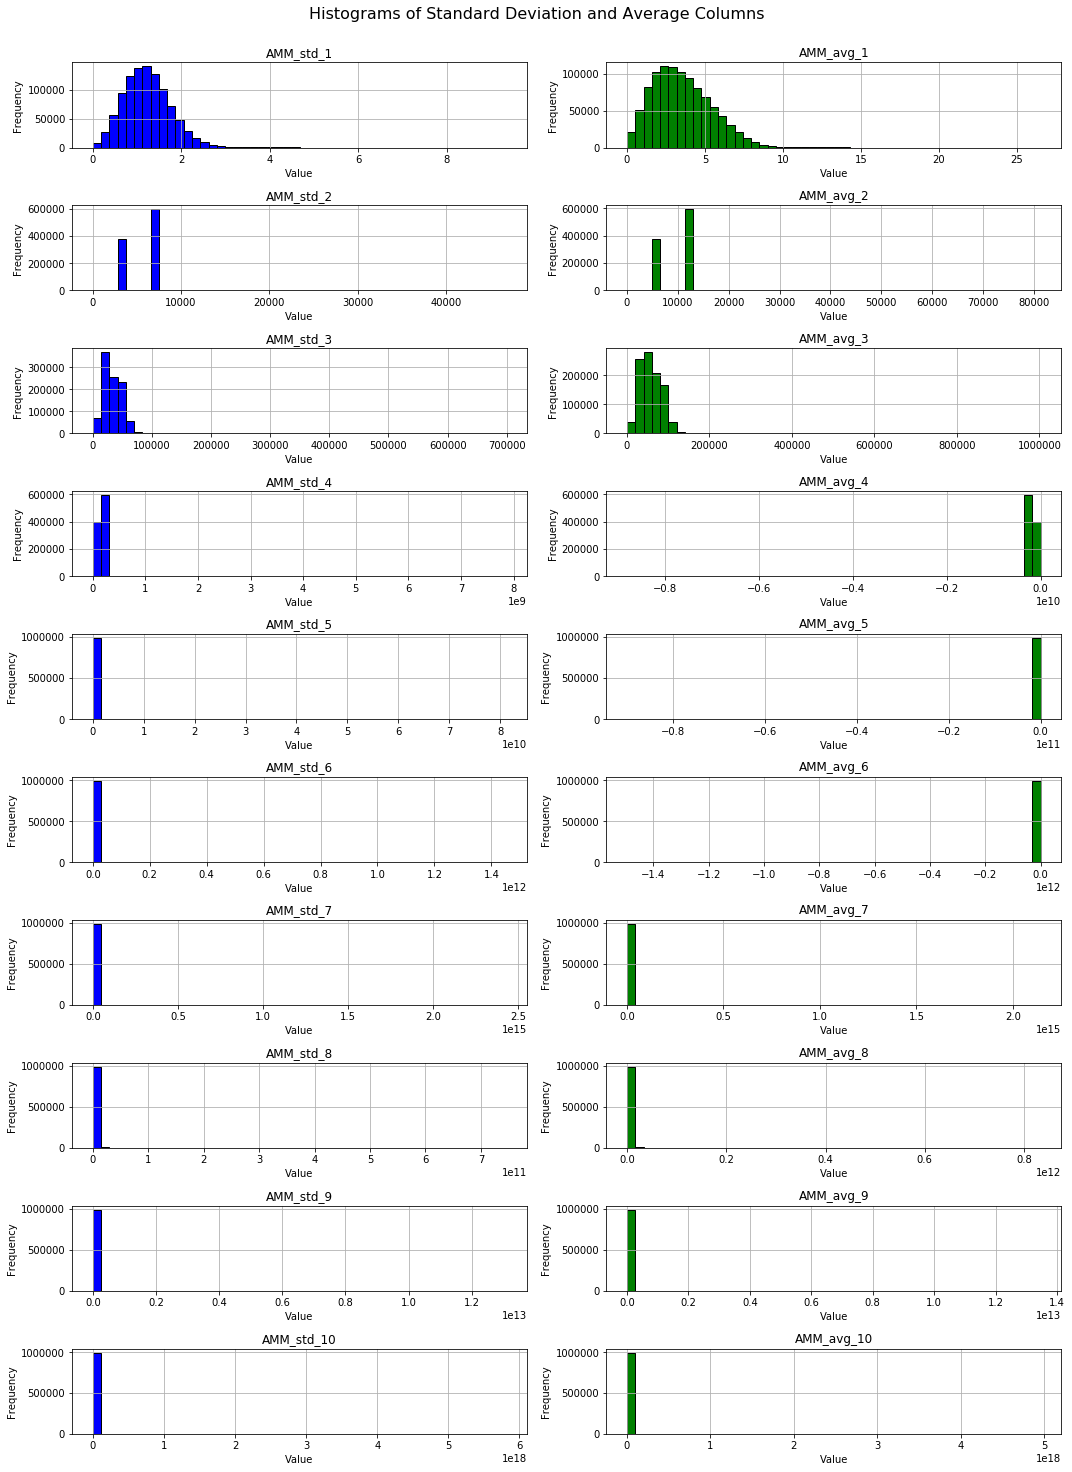

In [20]:
import matplotlib.pyplot as plt

# Convert the Spark DataFrame to Pandas for plotting
aom_data_pd = aom_data.toPandas()

# List of standard deviation and average columns (excluding the last column 'MSD_TRACKID')
std_columns = [f'AMM_std_{i+1}' for i in range(10)]
avg_columns = [f'AMM_avg_{i+1}' for i in range(10)]

# Plot histograms for std and avg columns side by side
plt.figure(figsize=(15, 20))

# Set the title for the entire figure
plt.suptitle('Histograms of Standard Deviation and Average Columns', fontsize=16, y=1.02)

for i in range(10):  # Loop over the 10 std and avg columns
    # Plot the standard deviation column
    plt.subplot(10, 2, 2*i + 1)
    aom_data_pd[std_columns[i]].hist(bins=50, color='blue', edgecolor='black')
    plt.title(f'{std_columns[i]}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    
    # Plot the corresponding average column
    plt.subplot(10, 2, 2*i + 2)
    aom_data_pd[avg_columns[i]].hist(bins=50, color='green', edgecolor='black')
    plt.title(f'{avg_columns[i]}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')


plt.tight_layout()

# Save and show the plot
#plt.savefig('features_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

#### A.4 Are any features strongly correlated?   

In [21]:
# Explore correlations
assembler = VectorAssembler(
    inputCols=[col for col in aom_data.columns if col.startswith("AMM")],
    outputCol="features"
)

data = assembler.transform(aom_data)
correlations = Correlation.corr(data, 'features', 'pearson')

print(correlations)

DataFrame[pearson(features): matrix]


In [22]:
# Collect correlations locally and convert to numpy array

correlations_local = correlations.collect()[0][0].toArray()

display(pd.DataFrame(correlations_local))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,1.000000,-0.019970,0.227683,0.013724,0.076598,0.105152,0.024142,0.076524,0.104952,0.045113,0.724618,-0.020833,0.226315,-0.013612,-0.076529,-0.104984,0.024111,0.076398,0.104699,0.044959
1,-0.019970,1.000000,0.786974,0.848546,0.796064,0.699139,0.692396,0.795602,0.698605,0.501698,0.026356,0.999567,0.782582,-0.848483,-0.794764,-0.695877,0.692130,0.794210,0.695302,0.499856
2,0.227683,0.786974,1.000000,0.681866,0.783786,0.794040,0.563798,0.783546,0.793502,0.550790,0.327493,0.786758,0.994414,-0.681873,-0.783322,-0.791362,0.563609,0.782950,0.790680,0.549286
3,0.013724,0.848546,0.681866,1.000000,0.945989,0.837624,0.962426,0.945701,0.837212,0.706433,0.009332,0.846566,0.675535,-0.999961,-0.944002,-0.833638,0.962245,0.943679,0.833230,0.704140
4,0.076598,0.796064,0.783786,0.945989,1.000000,0.964883,0.914948,0.999981,0.964623,0.849023,0.089381,0.794339,0.779299,-0.946023,-0.999485,-0.962367,0.914810,0.999448,0.962095,0.847423
5,0.105152,0.699139,0.794040,0.837624,0.964883,1.000000,0.814394,0.965123,0.999981,0.923738,0.129501,0.697522,0.791113,-0.837580,-0.965340,-0.998560,0.814197,0.965573,0.998509,0.922531
6,0.024142,0.692396,0.563798,0.962426,0.914948,0.814394,1.000000,0.914822,0.814140,0.741348,0.002544,0.690353,0.558051,-0.962579,-0.913193,-0.811050,0.999984,0.913074,0.810831,0.739312
7,0.076524,0.795602,0.783546,0.945701,0.999981,0.965123,0.914822,1.000000,0.964899,0.849679,0.089259,0.793878,0.779069,-0.945736,-0.999475,-0.962624,0.914684,0.999478,0.962391,0.848093
8,0.104952,0.698605,0.793502,0.837212,0.964623,0.999981,0.814140,0.964899,1.000000,0.924281,0.129195,0.696988,0.790588,-0.837168,-0.965089,-0.998560,0.813943,0.965360,0.998550,0.923090
9,0.045113,0.501698,0.550790,0.706433,0.849023,0.923738,0.741348,0.849679,0.924281,1.000000,0.035348,0.499883,0.549730,-0.706266,-0.850114,-0.923494,0.741079,0.850832,0.924060,0.999017


In [23]:
# Choose a threshold and visualize which correlations are above the threshold 

display(HTML(pd.DataFrame(correlations_local.round(1)).to_html(max_cols=30)))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,1.0,-0.0,0.2,0.0,0.1,0.1,0.0,0.1,0.1,0.0,0.7,-0.0,0.2,-0.0,-0.1,-0.1,0.0,0.1,0.1,0.0
1,-0.0,1.0,0.8,0.8,0.8,0.7,0.7,0.8,0.7,0.5,0.0,1.0,0.8,-0.8,-0.8,-0.7,0.7,0.8,0.7,0.5
2,0.2,0.8,1.0,0.7,0.8,0.8,0.6,0.8,0.8,0.6,0.3,0.8,1.0,-0.7,-0.8,-0.8,0.6,0.8,0.8,0.5
3,0.0,0.8,0.7,1.0,0.9,0.8,1.0,0.9,0.8,0.7,0.0,0.8,0.7,-1.0,-0.9,-0.8,1.0,0.9,0.8,0.7
4,0.1,0.8,0.8,0.9,1.0,1.0,0.9,1.0,1.0,0.8,0.1,0.8,0.8,-0.9,-1.0,-1.0,0.9,1.0,1.0,0.8
5,0.1,0.7,0.8,0.8,1.0,1.0,0.8,1.0,1.0,0.9,0.1,0.7,0.8,-0.8,-1.0,-1.0,0.8,1.0,1.0,0.9
6,0.0,0.7,0.6,1.0,0.9,0.8,1.0,0.9,0.8,0.7,0.0,0.7,0.6,-1.0,-0.9,-0.8,1.0,0.9,0.8,0.7
7,0.1,0.8,0.8,0.9,1.0,1.0,0.9,1.0,1.0,0.8,0.1,0.8,0.8,-0.9,-1.0,-1.0,0.9,1.0,1.0,0.8
8,0.1,0.7,0.8,0.8,1.0,1.0,0.8,1.0,1.0,0.9,0.1,0.7,0.8,-0.8,-1.0,-1.0,0.8,1.0,1.0,0.9
9,0.0,0.5,0.6,0.7,0.8,0.9,0.7,0.8,0.9,1.0,0.0,0.5,0.5,-0.7,-0.9,-0.9,0.7,0.9,0.9,1.0


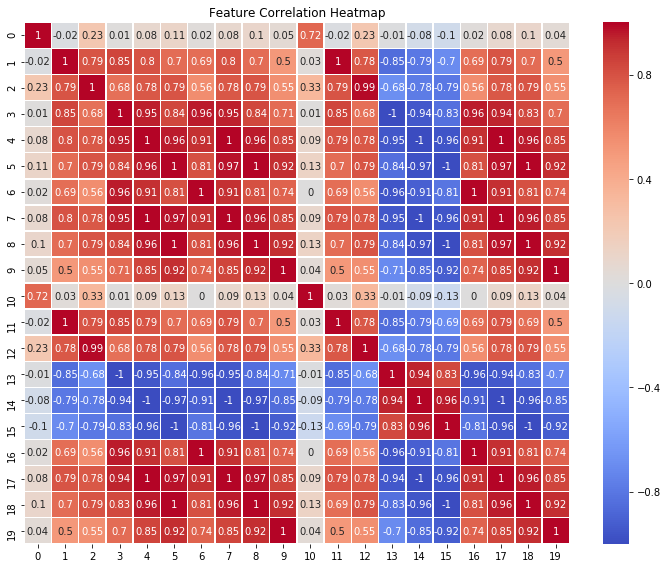

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert the correlation matrix to a Pandas DataFrame if not already done
correlations_df = pd.DataFrame(correlations_local)

# Round the correlation values to 1 decimal place
correlations_df = correlations_df.round(2)

# Plot the heatmap using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlations_df, annot=True, cmap='coolwarm', linewidths=0.5)

# Show the heatmap
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
#plt.savefig('correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

In [25]:
import pandas as pd
import numpy as np

# Assuming 'inputCols' contains the original column names from the VectorAssembler
inputCols = [col for col in aom_data.columns if col.startswith("AM")]  # Modify this as needed based on your data

# Set the threshold for "high" correlations (positive or negative)
high_correlation_threshold = 1

# Create an empty list to store high correlation pairs
high_correlation_pairs = []

# Iterate over the correlation matrix
for i in range(correlations_df.shape[0]):
    for j in range(i + 1, correlations_df.shape[1]):  # Avoid duplicate pairs
        correlation = correlations_df.iat[i, j]
        if abs(correlation) >= high_correlation_threshold:
            # Add the pair as a string using the real variable names instead of feature numbers
            feature_i = inputCols[i]
            feature_j = inputCols[j]
            high_correlation_pairs.append([f'{feature_i} & {feature_j}', correlation])

# Convert the list to a DataFrame for easier viewing
high_correlation_df = pd.DataFrame(high_correlation_pairs, columns=['Feature Pair', 'Correlation Score'])

# Show the result
high_correlation_df

,Feature Pair,Correlation Score
0,AMM_std_2 & AMM_avg_2,1.0
1,AMM_std_4 & AMM_avg_4,-1.0
2,AMM_std_5 & AMM_std_8,1.0
3,AMM_std_5 & AMM_avg_5,-1.0
4,AMM_std_5 & AMM_avg_8,1.0
5,AMM_std_6 & AMM_std_9,1.0
6,AMM_std_6 & AMM_avg_6,-1.0
7,AMM_std_6 & AMM_avg_9,1.0
8,AMM_std_7 & AMM_avg_7,1.0
9,AMM_std_8 & AMM_avg_5,-1.0


### B. Load the MSD Allmusic Genre Dataset (MAGD).

- Think about if we are predicting a specific genre is it gonna be an imbalance classification problem or not
- Merege genre and your audio feature dataset to ready actually train the model 

In [26]:
# Test loading genre dataset 
MAGD_test_genre = (spark.read.format('csv')
                  .option('header', False)
                  .option('delimiter', '\t')
                  .load('/data/msd/genre/msd-MAGD-genreAssignment.tsv')
                  .limit(10))

# show the result 
show_as_html(MAGD_test_genre, 5)

,_c0,_c1
0,TRAAAAK128F9318786,Pop_Rock
1,TRAAAAV128F421A322,Pop_Rock
2,TRAAAAW128F429D538,Rap
3,TRAAABD128F429CF47,Pop_Rock
4,TRAAACV128F423E09E,Pop_Rock


In [27]:
# Define the schema for the genre 
genre_schema = StructType([
    StructField("msd_track_id", StringType(), True),  # _c0 as track ID
    StructField("genre", StringType(), True)      # _c1 as genre
])

In [28]:
# Now load the dataset using the defined schema
MAGD_genre_data = spark.read.format('csv') \
    .option('header', False) \
    .option('delimiter', '\t') \
    .schema(genre_schema) \
    .load('/data/msd/genre/msd-MAGD-genreAssignment.tsv')

# show the result 
MAGD_genre_data.printSchema()
show_as_html(MAGD_genre_data, 5)

root
 |-- msd_track_id: string (nullable = true)
 |-- genre: string (nullable = true)



,msd_track_id,genre
0,TRAAAAK128F9318786,Pop_Rock
1,TRAAAAV128F421A322,Pop_Rock
2,TRAAAAW128F429D538,Rap
3,TRAAABD128F429CF47,Pop_Rock
4,TRAAACV128F423E09E,Pop_Rock


In [29]:
# The number of track_ID in MAGD_genre

MAGD_genre_data.count()

422714

#### B.1 Visualize the distribution of genres for the tracks that were matched

In [30]:
# Count the occurrences of each genre
genre_count = (MAGD_genre_data.groupBy('genre').
               agg(F.count('msd_track_id').alias('Number_of_Tracks')).
               orderBy(F.asc('Number_of_Tracks')))

# show the result 
show_as_html(genre_count, 21)

,genre,Number_of_Tracks
0,Holiday,200
1,Children,477
2,Classical,556
3,Avant_Garde,1014
4,Easy_Listening,1545
5,Stage,1614
6,Comedy_Spoken,2067
7,New Age,4010
8,Folk,5865
9,Vocal,6195


In [31]:
# Convert the result to Pandas for visualization
genre_count_pd = genre_count.toPandas()

In [32]:
# Calculate the total number of tracks
total_tracks = genre_count_pd['Number_of_Tracks'].sum()

# Add a new column 'percentage' by calculating the percentage of each genre
genre_count_pd['percentage'] = (genre_count_pd['Number_of_Tracks'] / total_tracks) * 100

# Round the percentage column to 2 decimal places
genre_count_pd['percentage'] = genre_count_pd['percentage'].round(2)

# show the result 
genre_count_pd

,genre,Number_of_Tracks,percentage
0,Holiday,200,0.05
1,Children,477,0.11
2,Classical,556,0.13
3,Avant_Garde,1014,0.24
4,Easy_Listening,1545,0.37
5,Stage,1614,0.38
6,Comedy_Spoken,2067,0.49
7,New Age,4010,0.95
8,Folk,5865,1.39
9,Vocal,6195,1.47


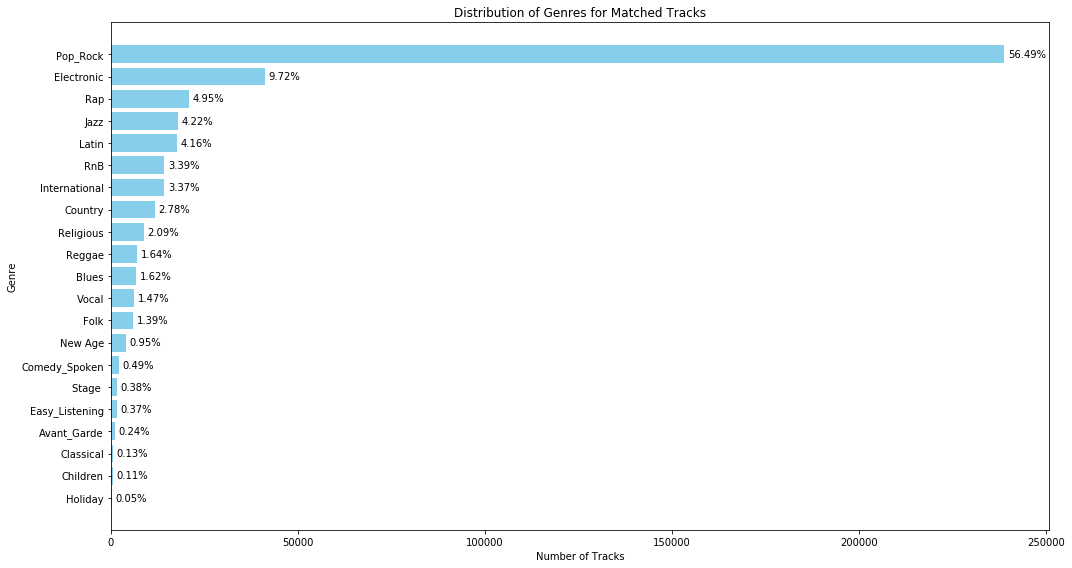

In [31]:
import matplotlib.pyplot as plt

# Plot the genre distribution as a horizontal bar chart
plt.figure(figsize=(15, 8))
bars = plt.barh(genre_count_pd['genre'], genre_count_pd['Number_of_Tracks'], color='skyblue')

# Add percentage annotations at the end of each bar
for bar, percentage in zip(bars, genre_count_pd['percentage']):
    plt.text(bar.get_width() + 1000, bar.get_y() + bar.get_height() / 2, f'{percentage:.2f}%', 
             va='center', color='black', fontsize=10)

# Add labels and title
plt.ylabel('Genre')
plt.xlabel('Number of Tracks')
plt.title('Distribution of Genres for Matched Tracks')
plt.tight_layout()

# Show the plot
#plt.savefig('Distribution of Genres.png', dpi=300, bbox_inches='tight')
plt.show()

### C. Merge the genres dataset and audio features datasets

In [33]:
# Convert Spark DataFrames to Pandas DataFrames
MAGD_genre_df = MAGD_genre_data.toPandas()
aom_df = aom_data.toPandas()

In [34]:
# Perform an inner join on 'MSD_TRACKID' and 'msd_track_id'
songs_with_genre = aom_df.merge(MAGD_genre_df, left_on='MSD_TRACKID', right_on='msd_track_id', how='inner')

# Drop the 'MSD_TRACKID' column after the join
songs_with_genre = songs_with_genre.drop(columns=['MSD_TRACKID'])

# show the result 
songs_with_genre.head(5)

,AMM_std_1,AMM_std_2,AMM_std_3,AMM_std_4,AMM_std_5,AMM_std_6,AMM_std_7,AMM_std_8,AMM_std_9,AMM_std_10,...,AMM_avg_3,AMM_avg_4,AMM_avg_5,AMM_avg_6,AMM_avg_7,AMM_avg_8,AMM_avg_9,AMM_avg_10,msd_track_id,genre
0,1.2000,3355.0,26270.0,39850000.0,3.096000e+08,2.403000e+09,8.749000e+11,2.775000e+09,2.155000e+10,4.064000e+14,...,43470.0,-44220000.0,-3.376000e+08,-2.576000e+09,7.665000e+11,3.015000e+09,2.302000e+10,3.460000e+14,TRHFHQZ12903C9E2D5,Jazz
1,1.8830,6712.0,49060.0,160600000.0,1.176000e+09,8.609000e+09,7.083000e+12,1.058000e+10,7.744000e+10,2.781000e+15,...,85200.0,-179100000.0,-1.316000e+09,-9.660000e+09,6.233000e+12,1.182000e+10,8.680000e+10,2.463000e+15,TRHFHAU128F9341A0E,Pop_Rock
2,1.3630,6710.0,28750.0,160500000.0,6.900000e+08,2.965000e+09,7.075000e+12,6.194000e+09,2.663000e+10,5.621000e+14,...,49990.0,-179000000.0,-7.713000e+08,-3.322000e+09,6.227000e+12,6.920000e+09,2.983000e+10,4.970000e+14,TRHFHYJ128F4234782,RnB
3,0.8262,3355.0,17310.0,39930000.0,2.080000e+08,1.082000e+09,8.775000e+11,1.857000e+09,9.673000e+09,1.248000e+14,...,30380.0,-44380000.0,-2.328000e+08,-1.220000e+09,7.700000e+11,2.073000e+09,1.088000e+10,1.103000e+14,TRHFHHR128F9339010,Latin
4,0.7786,6717.0,35320.0,160900000.0,8.322000e+08,4.300000e+09,7.108000e+12,7.480000e+09,3.867000e+10,9.783000e+14,...,60300.0,-179600000.0,-9.362000e+08,-4.878000e+09,6.259000e+12,8.417000e+09,4.389000e+10,8.812000e+14,TRHFHMB128F4213BC9,Pop_Rock


In [ ]:
# Save the data to HDFS in Parquet format
(songs_with_genre.write.mode('overwrite')
 .parquet("hdfs:///user/kda115/Assignment02/data/songs_with_genre.parquet"))

## Audio Similarity Question 02 

### B. Convert the genre column into a new binary label that represent if the track is "Electronic" or some other genre 


In [35]:
# Load the songs_with_genre parquet file back into a Spark DataFrame
songs_with_genre = spark.read.parquet('hdfs:///user/kda115/Assignment02/data/songs_with_genre.parquet')

# Show the result
songs_with_genre.printSchema()
show_as_html(songs_with_genre,5)

root
 |-- AMM_std_1: double (nullable = true)
 |-- AMM_std_2: double (nullable = true)
 |-- AMM_std_3: double (nullable = true)
 |-- AMM_std_4: double (nullable = true)
 |-- AMM_std_5: double (nullable = true)
 |-- AMM_std_6: double (nullable = true)
 |-- AMM_std_7: double (nullable = true)
 |-- AMM_std_8: double (nullable = true)
 |-- AMM_std_9: double (nullable = true)
 |-- AMM_std_10: double (nullable = true)
 |-- AMM_avg_1: double (nullable = true)
 |-- AMM_avg_2: double (nullable = true)
 |-- AMM_avg_3: double (nullable = true)
 |-- AMM_avg_4: double (nullable = true)
 |-- AMM_avg_5: double (nullable = true)
 |-- AMM_avg_6: double (nullable = true)
 |-- AMM_avg_7: double (nullable = true)
 |-- AMM_avg_8: double (nullable = true)
 |-- AMM_avg_9: double (nullable = true)
 |-- AMM_avg_10: double (nullable = true)
 |-- msd_track_id: string (nullable = true)
 |-- genre: string (nullable = true)



,AMM_std_1,AMM_std_2,AMM_std_3,AMM_std_4,AMM_std_5,AMM_std_6,AMM_std_7,AMM_std_8,AMM_std_9,AMM_std_10,...,AMM_avg_3,AMM_avg_4,AMM_avg_5,AMM_avg_6,AMM_avg_7,AMM_avg_8,AMM_avg_9,AMM_avg_10,msd_track_id,genre
0,1.3530,6709.0,34770.0,160500000.0,8.346000e+08,4.339000e+09,7.075000e+12,7.494000e+09,3.898000e+10,9.937000e+14,...,60010.0,-179000000.0,-9.277000e+08,-4.805000e+09,6.227000e+12,8.320000e+09,4.312000e+10,8.685000e+14,TROVQKM128F9316E59,Pop_Rock
1,1.4280,6712.0,48250.0,160600000.0,1.129000e+09,7.922000e+09,7.085000e+12,1.015000e+10,7.123000e+10,2.433000e+15,...,77860.0,-179200000.0,-1.225000e+09,-8.383000e+09,6.239000e+12,1.101000e+10,7.533000e+10,2.044000e+15,TROVQAK128E0781B79,Pop_Rock
2,1.6200,3353.0,30780.0,39940000.0,3.666000e+08,3.363000e+09,8.782000e+11,3.293000e+09,3.022000e+10,6.773000e+14,...,52720.0,-44450000.0,-4.070000e+08,-3.722000e+09,7.715000e+11,3.648000e+09,3.340000e+10,5.925000e+14,TROVQSD128F42283D2,Pop_Rock
3,1.0700,3354.0,23280.0,39960000.0,2.804000e+08,1.965000e+09,8.790000e+11,2.515000e+09,1.764000e+10,3.042000e+14,...,40850.0,-44490000.0,-3.135000e+08,-2.207000e+09,7.723000e+11,2.807000e+09,1.978000e+10,2.687000e+14,TROVQBK128F42992E8,Pop_Rock
4,0.5706,6727.0,31660.0,161300000.0,7.530000e+08,3.516000e+09,7.132000e+12,6.693000e+09,3.127000e+10,7.161000e+14,...,53980.0,-179900000.0,-8.392000e+08,-3.910000e+09,6.278000e+12,7.451000e+09,3.476000e+10,6.377000e+14,TROVQFG128F92CD6DC,Electronic


In [7]:
# Convert the genre column into binary column 
# feature_genre_binary = feature_genre.withColumn('class', F.when(F.col('genre') == 'Electronic', 1).otherwise(0))
songs_with_genre = songs_with_genre.withColumn(
    'class',
    F.when(F.col('genre') == 'Electronic',1).otherwise(0)
    )

# show the result 
show_as_html(songs_with_genre, 5)

,AMM_std_1,AMM_std_2,AMM_std_3,AMM_std_4,AMM_std_5,AMM_std_6,AMM_std_7,AMM_std_8,AMM_std_9,AMM_std_10,...,AMM_avg_4,AMM_avg_5,AMM_avg_6,AMM_avg_7,AMM_avg_8,AMM_avg_9,AMM_avg_10,msd_track_id,genre,class
0,1.3530,6709.0,34770.0,160500000.0,8.346000e+08,4.339000e+09,7.075000e+12,7.494000e+09,3.898000e+10,9.937000e+14,...,-179000000.0,-9.277000e+08,-4.805000e+09,6.227000e+12,8.320000e+09,4.312000e+10,8.685000e+14,TROVQKM128F9316E59,Pop_Rock,0
1,1.4280,6712.0,48250.0,160600000.0,1.129000e+09,7.922000e+09,7.085000e+12,1.015000e+10,7.123000e+10,2.433000e+15,...,-179200000.0,-1.225000e+09,-8.383000e+09,6.239000e+12,1.101000e+10,7.533000e+10,2.044000e+15,TROVQAK128E0781B79,Pop_Rock,0
2,1.6200,3353.0,30780.0,39940000.0,3.666000e+08,3.363000e+09,8.782000e+11,3.293000e+09,3.022000e+10,6.773000e+14,...,-44450000.0,-4.070000e+08,-3.722000e+09,7.715000e+11,3.648000e+09,3.340000e+10,5.925000e+14,TROVQSD128F42283D2,Pop_Rock,0
3,1.0700,3354.0,23280.0,39960000.0,2.804000e+08,1.965000e+09,8.790000e+11,2.515000e+09,1.764000e+10,3.042000e+14,...,-44490000.0,-3.135000e+08,-2.207000e+09,7.723000e+11,2.807000e+09,1.978000e+10,2.687000e+14,TROVQBK128F42992E8,Pop_Rock,0
4,0.5706,6727.0,31660.0,161300000.0,7.530000e+08,3.516000e+09,7.132000e+12,6.693000e+09,3.127000e+10,7.161000e+14,...,-179900000.0,-8.392000e+08,-3.910000e+09,6.278000e+12,7.451000e+09,3.476000e+10,6.377000e+14,TROVQFG128F92CD6DC,Electronic,1


#### B.1 What is the Class Balance of the binary model?

To determine the class balance of  binary model, we can count the number of instances for each class where class = 1 for Electronic and class = 0 for other genres

In [8]:
# Count the number of tracks for each class (Electronic vs. Other)
class_balance = songs_with_genre.groupBy('class').count()

# Total number of tracks
total_tracks = songs_with_genre.count()

# Calculate the percentage for each class
class_balance = class_balance.withColumn(
    'percentage', 
    (class_balance['count'] / total_tracks) * 100
)

# Rename the class values
class_balance = class_balance.withColumn(
    'class', 
    F.when(class_balance['class'] == 1, 'Electronic').otherwise('Non-Electronic')
)

# Show the updated result with percentages
show_as_html(class_balance)

,class,count,percentage
0,Electronic,40662,9.667526
1,Non-Electronic,379942,90.332474


In [9]:
import matplotlib.pyplot as plt

# Convert to Pandas for easier plotting
class_balance_pd = class_balance.toPandas()

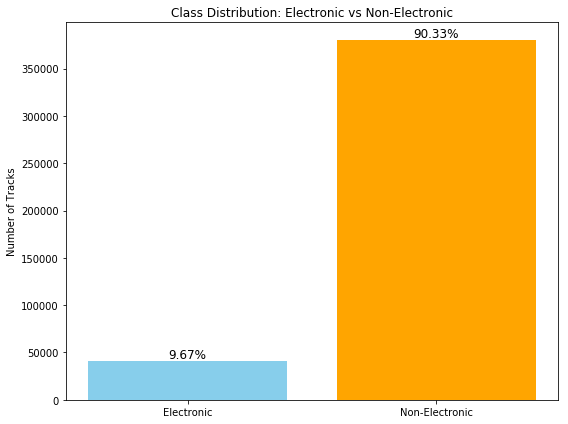

In [10]:
# Create the bar plot showing the real number of each class
plt.figure(figsize=(8, 6))
bars = plt.bar(class_balance_pd['class'], class_balance_pd['count'], color=['skyblue', 'orange'])

# Add percentage annotations on top of each bar
for bar, percentage in zip(bars, class_balance_pd['percentage']):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 5, f'{percentage:.2f}%', 
             ha='center', va='bottom', fontsize=12, color='black')

# Add labels and title
plt.ylabel('Number of Tracks')
plt.title('Class Distribution: Electronic vs Non-Electronic')

# Show the plot
plt.tight_layout()
#plt.savefig('Class_Distribution.png', dpi=300, bbox_inches='tight')
plt.show()

### C. Split the dataset use stratified random sampling and resampling technique 

#### C.1 Stratify Random Split 

In [11]:
# Assemble all the feature columns (those that start with "AMM_") into a single "features" vector column
assembler = VectorAssembler(
    inputCols=[col for col in songs_with_genre.columns if col.startswith("AMM_")],
    outputCol="features"
)

# Apply the assembler to transform the dataset
data = assembler.transform(songs_with_genre)

# Select the relevant columns: label (class), and features
data = data.select(
    F.col('class').alias('label'),
    F.col('features')
)

# Show the transformed data
show_as_html(data)

,label,features
0,0,"[1.353, 6709.0, 34770.0, 160500000.0, 83460000..."
1,0,"[1.428, 6712.0, 48250.0, 160600000.0, 11290000..."
2,0,"[1.62, 3353.0, 30780.0, 39940000.0, 366600000...."
3,0,"[1.07, 3354.0, 23280.0, 39960000.0, 280400000...."
4,1,"[0.5706, 6727.0, 31660.0, 161300000.0, 7530000..."
5,0,"[1.267, 6709.0, 55000.0, 160500000.0, 13170000..."
6,0,"[1.117, 3355.0, 11910.0, 40000000.0, 144400000..."
7,0,"[0.8293, 6721.0, 44440.0, 161200000.0, 1067000..."
8,0,"[1.608, 3358.0, 29040.0, 40090000.0, 351100000..."
9,0,"[1.584, 3359.0, 16990.0, 40110000.0, 202400000..."


In [12]:
# Exact stratification using Window (multi-class, counts computed automatically)

temp = (
    data
    .withColumn("id", F.monotonically_increasing_id())
    .withColumn("random", F.rand())  # random number between 0 and 1
    .withColumn(
        "row",
        F.row_number()  # row number in each class partition (0, 1, 2, ...)
        .over(
            Window
            .partitionBy("label")
            .orderBy("random")
        )
    )
)

counts = (
    data
    .groupBy("label")
    .count()
    .toPandas()
    .set_index("label")["count"]
    .to_dict()
)
labels = sorted(counts.keys())

print(counts)

training = temp
for label in labels:
    training = training.where((F.col("label") != label) | (F.col("row") < counts[label] * 0.8))

training.cache()

test = temp.join(training, on="id", how="left_anti")
test.cache()

training = training.drop("id", "random", "row")
test = test.drop("id", "random", "row")

show_class_balance(data, "data")
show_class_balance(training, "training")
show_class_balance(test, "test")

{1: 40662, 0: 379942}
Class balance [data]

total:   420604
counts:
   label   count     ratio
0      1   40662  0.096675
1      0  379942  0.903325

Class balance [training]

total:   336482
counts:
   label   count     ratio
0      1   32529  0.096674
1      0  303953  0.903326

Class balance [test]

total:   84122
counts:
   label  count     ratio
0      1   8133  0.096681
1      0  75989  0.903319



In [13]:
# Ensure datasets are cached

data.cache()
training.cache()
test.cache()

DataFrame[label: int, features: vector]

In [14]:
show_as_html(training)

,label,features
0,1,"[0.8308, 6722.0, 35760.0, 161100000.0, 8504000..."
1,1,"[0.8546, 6725.0, 59290.0, 161300000.0, 1460000..."
2,1,"[0.7693, 3358.0, 25100.0, 40060000.0, 29910000..."
3,1,"[0.8901, 6731.0, 39070.0, 161500000.0, 9367000..."
4,1,"[0.3476, 6708.0, 38320.0, 160400000.0, 8439000..."
5,1,"[0.6206, 3357.0, 6661.0, 39960000.0, 82590000...."
6,1,"[0.5919, 6716.0, 37280.0, 160800000.0, 8833000..."
7,1,"[2.06, 6713.0, 50890.0, 160700000.0, 121200000..."
8,1,"[0.6306, 6729.0, 41220.0, 161400000.0, 1034000..."
9,1,"[1.671, 6714.0, 29070.0, 160700000.0, 70620000..."


### C.2 Resampling Method

### C.2.1 No Sampling

In [15]:
# standard scaling for down sampling
standard_scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withMean=True, withStd=True)

# Fit the StandardScaler model on the training data
scaler_no_sampling = standard_scaler.fit(training)

# Transform the training data
scaled_training_nosampled = scaler_no_sampling.transform(training)

# Transform the test data using the same scaler model
scaled_nosampled_test = scaler_no_sampling.transform(test)

### C.2.1 Down Sampling

In [16]:
# Downsampling

training_downsampled = (
    training
    .withColumn("random", F.rand())
    .where((F.col("label") != 0) | ((F.col("label") == 0) & (F.col("random") < 2 * (40662 / 379942))))
)
training_downsampled.cache()

show_class_balance(training_downsampled, "training (downsampled)")

Class balance [training (downsampled)]

total:   98005
counts:
   label  count     ratio
0      1  32529  0.331912
1      0  65476  0.668088



In [17]:
# standard scaling for down sampling
standard_scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withMean=True, withStd=True)

# Fit the StandardScaler model on the training data
scaler_down_sampling = standard_scaler.fit(training_downsampled)

# Transform the training data
scaled_training_downsampled = scaler_down_sampling.transform(training_downsampled)

# Transform the test data using the same scaler model
scaled_downsampled_test = scaler_down_sampling.transform(test)

#### C.2.2 Up Sampling

In [18]:
# Upsampling via poisson random sampling

counts = {label: count for label, count in training.groupBy("label").count().collect()}
count_lower_bound = 50000 
#count_upper_bound = 300000

def random_upsample(x, counts, count_lower_bound):

    count = counts[x]

    if count < count_lower_bound:
        return [x] * int(1 + np.random.poisson((count_lower_bound - count) / count))  # randomly upsample to count_lower_bound
    
    return [x]  # do nothing

random_upsample_udf = F.udf(lambda x: random_upsample(x, counts, count_lower_bound), ArrayType(IntegerType()))
training_upsampled = (
    training
    .withColumn("sample", random_upsample_udf(F.col("label")))
    .select(
        F.col("label"),
        F.col("features"),
        F.explode(F.col("sample")).alias("sample")
    )
    .drop("sample")
)

show_class_balance(training_upsampled, "training (upsampled)")

Class balance [training (upsampled)]

total:   353844
counts:
   label   count     ratio
0      1   50007  0.141325
1      0  303953  0.859003



In [19]:
# standard scaling for up sampling
standard_scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withMean=True, withStd=True)

# Fit the StandardScaler model on the training data
scaler_upsampling = standard_scaler.fit(training_upsampled)

# Transform the training data
scaled_training_upsampled = scaler_upsampling.transform(training_upsampled)

# Transform the test data using the same scaler model
scaled_upsampled_test = scaler_upsampling.transform(test)

#### C.2.3  ReSampling

In [20]:
# Resampling via poisson random sampling

counts = {label: count for label, count in training.groupBy("label").count().collect()}
count_lower_bound = 50000
count_upper_bound = 200000

def random_resample(x, counts, count_lower_bound, count_upper_bound):

    count = counts[x]

    if count < count_lower_bound:
        return [x] * int(1 + np.random.poisson((count_lower_bound - count) / count))  # randomly upsample to count_lower_bound

    if count > count_upper_bound:
        if np.random.rand() < count_upper_bound / count: # randomly downsample to count_upper_bound
            return [x]
        else:
            return []

    return [x]  # do nothing

random_resample_udf = F.udf(lambda x: random_resample(x, counts, count_lower_bound, count_upper_bound), ArrayType(IntegerType()))
training_resampled = (
    training
    .withColumn("sample", random_resample_udf(F.col("label")))
    .select(
        F.col("label"),
        F.col("features"),
        F.explode(F.col("sample")).alias("sample")
    )
    .drop("sample")
)

show_class_balance(training_resampled, "training (resampled)")

Class balance [training (resampled)]

total:   181235
counts:
   label   count     ratio
0      1   50034  0.276073
1      0  131111  0.723431



In [21]:
# standard scaling for re sampling
standard_scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withMean=True, withStd=True)

# Fit the StandardScaler model on the training data
scaler_resampling = standard_scaler.fit(training_resampled)

# Transform the training data
scaled_training_resampled = scaler_resampling.transform(training_resampled)

# Transform the test data using the same scaler model
scaled_resampled_test = scaler_resampling.transform(test)

#### C.2.4 Observation reweighting

In [22]:
# Observation reweighting

training_weighted = training.withColumn(
    "weight",
    F.when(F.col("label") == 0, 1.0) # when the label is 0, give 0.5 weight
     .when(F.col("label") == 1, 5.0) # when label is 1, give 5.0 weight
     .otherwise(1.0)
)

training_weighted.printSchema()
show_as_html(training_weighted)

weights = (
    training_weighted
    .groupBy("label")
    .agg(
        F.collect_set(F.col("weight")).alias("weights")
    )
    .toPandas()
)
print(weights)

root
 |-- label: integer (nullable = false)
 |-- features: vector (nullable = true)
 |-- weight: double (nullable = false)



,label,features,weight
0,1,"[0.8308, 6722.0, 35760.0, 161100000.0, 8504000...",5.0
1,1,"[0.8546, 6725.0, 59290.0, 161300000.0, 1460000...",5.0
2,1,"[0.7693, 3358.0, 25100.0, 40060000.0, 29910000...",5.0
3,1,"[0.8901, 6731.0, 39070.0, 161500000.0, 9367000...",5.0
4,1,"[0.3476, 6708.0, 38320.0, 160400000.0, 8439000...",5.0
5,1,"[0.6206, 3357.0, 6661.0, 39960000.0, 82590000....",5.0
6,1,"[0.5919, 6716.0, 37280.0, 160800000.0, 8833000...",5.0
7,1,"[2.06, 6713.0, 50890.0, 160700000.0, 121200000...",5.0
8,1,"[0.6306, 6729.0, 41220.0, 161400000.0, 1034000...",5.0
9,1,"[1.671, 6714.0, 29070.0, 160700000.0, 70620000...",5.0


   label weights
0      1   [5.0]
1      0   [1.0]


In [23]:
# standard scaling for reweighted
standard_scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withMean=True, withStd=True)

# Fit the StandardScaler model on the training data
scaler_reweighted = standard_scaler.fit(training_weighted)

# Transform the training data
scaled_training_reweighted = scaler_reweighted.transform(training_weighted)

# Transform the test data using the same scaler model
scaled_reweighted_test = scaler_reweighted.transform(test)

### D. Train and Predict each of the three classification algorithms

In [7]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.functions import rand

In [40]:
# Take a random subset of your training data (e.g., 10% of the data)
validation_set = training.orderBy(rand()).limit(int(training.count() * 0.1))

# Define the Logistic Regression model with Lasso (L1 regularization)
lasso_lr = LogisticRegression(featuresCol='features', labelCol='label', elasticNetParam=1.0)

# Create a parameter grid to tune the lambda (regParam) for Lasso
paramGrid = (ParamGridBuilder() 
    .addGrid(lasso_lr.regParam, [0, 0.001, 0.01, 0.1, 1.0, 10.0]) 
    .build())

In [41]:
# Create a BinaryClassificationEvaluator for the evaluation metric (e.g., areaUnderROC)
evaluator = BinaryClassificationEvaluator(labelCol='label', rawPredictionCol='rawPrediction', metricName='areaUnderROC')

# Set up the CrossValidator with the model, paramGrid, and evaluator
crossval = CrossValidator(estimator=lasso_lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)  # 5-fold cross-validation

# Run cross-validation and choose the best model
cv_model = crossval.fit(validation_set)

# Get the best model
best_model = cv_model.bestModel

# Show the best lambda (regParam)
print(f"Best lambda (regParam): {best_model._java_obj.getRegParam()}")

Best lambda (regParam): 0.0


#### D.1 Logistic Regression Model

##### D.1.1 No Sampling  Model

In [47]:
# Training Logistic regression model with No Sampling
lr_no_sampling = LogisticRegression(featuresCol='features', 
                                    labelCol='label')
                                    #regParam=0.01, 
                                    #elasticNetParam=1.0)

lr_no_sampled_model = lr_no_sampling.fit(scaled_training_nosampled)

# Predict Logistic Regression with No Sampling
lr_no_sampled_pred = lr_no_sampled_model.transform(scaled_nosampled_test)
lr_no_sampled_pred.cache()

show_metrics(lr_no_sampled_pred)

Metrics [data]

threshold: 0.5

total:     84122

nP actual: 8133
nN actual: 75989

nP:        83
nN:        84039

TP         35
FP         48
FN         8098
TN         75941

precision: 0.42168675
recall:    0.00430346
accuracy:  0.90316445

auroc:     0.63026917


##### D.1.2  ReSampling Model

In [52]:
# Training Logistic regression model with Up Sampling 0.607
lr_upsampled = LogisticRegression(
    featuresCol='features', 
    labelCol='label'
    #regParam=0.01, 
    #elasticNetParam=1.0
)
lr_model_upsampled = lr_upsampled.fit(scaled_training_resampled)

# Predict Logistic Regression with No Sampling
lr_resampled_pred = lr_model_upsampled.transform(scaled_resampled_test)
lr_resampled_pred.cache()

# Show the result
show_metrics(lr_resampled_pred)

Metrics [data]

threshold: 0.5

total:     84122

nP actual: 8133
nN actual: 75989

nP:        757
nN:        83365

TP         243
FP         514
FN         7890
TN         75475

precision: 0.32100396
recall:    0.02987827
accuracy:  0.90009748

auroc:     0.63296484


##### D.1.2  UpSampling

In [49]:
# Training Logistic Regression model with Up Sampling
lr_upsampled = LogisticRegression(
    featuresCol='features', 
    labelCol='label'
    #regParam=0.01, 
    #elasticNetParam=1.0
)
lr_model_upsampled = lr_upsampled.fit(scaled_training_upsampled)

# Predict Logistic Regression with No Sampling
lr_upsampled_pred = lr_model_upsampled.transform(scaled_upsampled_test)
lr_upsampled_pred.cache()

# Show the result
show_metrics(lr_upsampled_pred)

Metrics [data]

threshold: 0.5

total:     84122

nP actual: 8133
nN actual: 75989

nP:        126
nN:        83996

TP         48
FP         78
FN         8085
TN         75911

precision: 0.38095238
recall:    0.00590188
accuracy:  0.90296236

auroc:     0.63066662


##### D.1.3 Down Sampling  Model

In [53]:
# Training Logistic Regression model with Down Sampling
lr_downsampled = LogisticRegression(
    featuresCol='features', 
    labelCol='label'
    #regParam=0.01, 
    #elasticNetParam=1.0
)
lr_model_downsampled = lr_downsampled.fit(scaled_training_downsampled)

# Predict Logistic Regression with No Sampling
lr_downsampled_pred = lr_model_downsampled.transform(scaled_downsampled_test)
lr_downsampled_pred.cache()

# Show the result
show_metrics(lr_downsampled_pred)

Metrics [data]

threshold: 0.5

total:     84122

nP actual: 8133
nN actual: 75989

nP:        1878
nN:        82244

TP         538
FP         1340
FN         7595
TN         74649

precision: 0.28647497
recall:    0.06615025
accuracy:  0.89378522

auroc:     0.63255349


##### D.1.4 Observation Reweighted  Model

In [51]:
# Training Logistic Regression model with Observation Reweighting 
lr_reweighted = LogisticRegression(
    featuresCol='features', 
    labelCol='label', 
    weightCol="weight"
    #regParam=0.01
    #elasticNetParam=1.0
)
lr_model_reweighted = lr_reweighted.fit(scaled_training_reweighted)

# Predict Logistic Regression with No Sampling
lr_reweighted_pred = lr_model_reweighted.transform(scaled_reweighted_test)
lr_reweighted_pred.cache()

# Show the result
show_metrics(lr_reweighted_pred)

Metrics [data]

threshold: 0.5

total:     84122

nP actual: 8133
nN actual: 75989

nP:        3023
nN:        81099

TP         766
FP         2257
FN         7367
TN         73732

precision: 0.25339067
recall:    0.09418419
accuracy:  0.88559473

auroc:     0.63268372


#### D.2 Random Forest Model 

Random Forest and Gradient Boosted Tree models inherently perform feature selection as part of their training process, as they split the data based on the most important features at each node. Thus, we do not need to apply regularization like Lasso for these models, as the splitting mechanism naturally selects the most relevant features.                   

##### D.2.1 No Sampling

In [26]:
# Training Ranfom Forest model with No Sampling
rf_no_sampled = RandomForestClassifier(featuresCol='features', labelCol='label')
rf_no_sampled_model = rf_no_sampled.fit(training)

# Predict Ranfom Forest with No Sampling
rf_no_sampled_pred = rf_no_sampled_model.transform(test)
rf_no_sampled_pred.cache()

# Show the result 
show_metrics(rf_no_sampled_pred)

Metrics [data]

threshold: 0.5

total:     84122

nP actual: 8133
nN actual: 75989

nP:        18
nN:        84104

TP         12
FP         6
FN         8121
TN         75983

precision: 0.66666667
recall:    0.00147547
accuracy:  0.90339031

auroc:     0.66340745


##### D.2.2 ReSampling

In [27]:
# Training Ranfom Forest model with ReSampling
rf_resampled = RandomForestClassifier(featuresCol='features', labelCol='label')
rf_resampled_model = rf_resampled.fit(training_resampled)


# Predict Ranfom Forest with Up Sampling
rf_resampled_pred = rf_resampled_model.transform(test)
rf_resampled_pred.cache()

# show the result 
show_metrics(rf_resampled_pred)

Metrics [data]

threshold: 0.5

total:     84122

nP actual: 8133
nN actual: 75989

nP:        307
nN:        83815

TP         180
FP         127
FN         7953
TN         75862

precision: 0.58631922
recall:    0.02213205
accuracy:  0.90394903

auroc:     0.65962189


##### D.2.2 UpSampling

In [37]:
# Training Ranfom Forest model with UpSampling
rf_upsampled = RandomForestClassifier(featuresCol='features', labelCol='label')
rf_upsampled_model = rf_upsampled.fit(training_upsampled)


# Predict Ranfom Forest with Up Sampling
rf_upsampled_pred = rf_upsampled_model.transform(test)
rf_upsampled_pred.cache()

# show the result 
show_metrics(rf_upsampled_pred)

Metrics [data]

threshold: 0.5

total:     84122

nP actual: 8133
nN actual: 75989

nP:        425
nN:        83697

TP         225
FP         200
FN         7908
TN         75789

precision: 0.52941176
recall:    0.02766507
accuracy:  0.90361618

auroc:     0.66429549


##### D.2.3 Down Sampling

In [28]:
# Training Ranfom Forest model with Down Sampling
rf_downsampled = RandomForestClassifier(featuresCol='features', labelCol='label')
rf_downsampled_model = rf_downsampled.fit(training_downsampled)

# Predict Ranfom Forest with Down Sampling
rf_downsampled_pred = rf_downsampled_model.transform(test)
rf_downsampled_pred.cache()

# show the result 
show_metrics(rf_downsampled_pred)

Metrics [data]

threshold: 0.5

total:     84122

nP actual: 8133
nN actual: 75989

nP:        5530
nN:        78592

TP         1522
FP         4008
FN         6611
TN         71981

precision: 0.27522604
recall:    0.18713882
accuracy:  0.87376667

auroc:     0.67572113


In [29]:
# Training Random Forest model with Observation Reweighting 
rf_reweighted = RandomForestClassifier(
    featuresCol='features', 
    labelCol='label', 
    weightCol="weight"
)
rf_model_reweighted = rf_reweighted.fit(training_weighted)

# Predict Logistic Regression with No Sampling
rf_reweighted_pred = rf_model_reweighted.transform(test)
rf_reweighted_pred.cache()

# Show the result
show_metrics(rf_reweighted_pred)

Metrics [data]

threshold: 0.5

total:     84122

nP actual: 8133
nN actual: 75989

nP:        6550
nN:        77572

TP         1744
FP         4806
FN         6389
TN         71183

precision: 0.26625954
recall:    0.21443502
accuracy:  0.86691947

auroc:     0.67703079


#### D.3 Gradient Boosted Trees

##### D.3.1 No Sampling

In [30]:
# Train the Gradient Boosted Tree Model 
gbt = GBTClassifier(featuresCol='features', labelCol='label')
gbt_nosampled_model = gbt.fit(training)

# Predict Gradient Boosted Tree with No Sampling 
gbt_nosampled_pred = gbt_nosampled_model.transform(test)
gbt_nosampled_pred.cache()

show_metrics(gbt_nosampled_pred)

Metrics [data]

threshold: 0.5

total:     84122

nP actual: 8133
nN actual: 75989

nP:        316
nN:        83806

TP         182
FP         134
FN         7951
TN         75855

precision: 0.57594937
recall:    0.02237797
accuracy:  0.90388959

auroc:     0.70666751


##### D.3.2 ReSampling

In [31]:
# Train the Gradient Boosted Tree Model ReSampling  
gbt = GBTClassifier(featuresCol='features', labelCol='label')
gbt_resampled_model = gbt.fit(training_resampled)

# Predict Gradient Boosted Tree with No Sampling 
gbt_resampled_pred = gbt_resampled_model.transform(test)
gbt_resampled_pred.cache()

# shoe the result 
show_metrics(gbt_resampled_pred)

Metrics [data]

threshold: 0.5

total:     84122

nP actual: 8133
nN actual: 75989

nP:        504
nN:        83618

TP         257
FP         247
FN         7876
TN         75742

precision: 0.50992063
recall:    0.03159966
accuracy:  0.90343786

auroc:     0.71079456


##### D.3.2 UpSampling

In [38]:
# Train the Gradient Boosted Tree Model Up Sampling  
gbt = GBTClassifier(featuresCol='features', labelCol='label')
gbt_upsampled_model = gbt.fit(training_upsampled)

# Predict Gradient Boosted Tree with No Sampling 
gbt_upsampled_pred = gbt_upsampled_model.transform(test)
gbt_upsampled_pred.cache()

# show the result 
show_metrics(gbt_upsampled_pred)

Metrics [data]

threshold: 0.5

total:     84122

nP actual: 8133
nN actual: 75989

nP:        513
nN:        83609

TP         267
FP         246
FN         7866
TN         75743

precision: 0.52046784
recall:    0.03282921
accuracy:  0.90356863

auroc:     0.70921363


##### D.3.3 Down Sampling

In [32]:
# Train the Gradient Boosted Tree Model Up Sampling  
gbt = GBTClassifier(featuresCol='features', labelCol='label')
gbt_downsampled_model = gbt.fit(training_downsampled)

# Predict Gradient Boosted Tree with No Sampling 
gbt_downsampled_pred = gbt_downsampled_model.transform(test)
gbt_downsampled_pred.cache()

# shoe the result 
show_metrics(gbt_downsampled_pred)

Metrics [data]

threshold: 0.5

total:     84122

nP actual: 8133
nN actual: 75989

nP:        8487
nN:        75635

TP         2239
FP         6248
FN         5894
TN         69741

precision: 0.26381525
recall:    0.27529817
accuracy:  0.85566201

auroc:     0.71634123


##### D.3.4 Observation Reweighted 

In [33]:
# Training Logistic Regression model with Observation Reweighting 
gbt_reweighted = GBTClassifier(
    featuresCol='features', 
    labelCol='label', 
    weightCol="weight"
)
gbt_model_reweighted = gbt_reweighted.fit(training_weighted)

# Predict Logistic Regression with No Sampling
gbt_reweighted_pred = gbt_model_reweighted.transform(test)
gbt_reweighted_pred.cache()

# Show the result
show_metrics(gbt_reweighted_pred)

Metrics [data]

threshold: 0.5

total:     84122

nP actual: 8133
nN actual: 75989

nP:        8800
nN:        75322

TP         2296
FP         6504
FN         5837
TN         69485

precision: 0.26090909
recall:    0.28230665
accuracy:  0.85329640

auroc:     0.71201466


## Audio Similarity Question 03

### B. Convert the genre column into an integer label that encodes genre consistently

In [8]:
# Create an indexer object to convert the 'genre' column to a 'label' column
indexer = StringIndexer(inputCol="genre", outputCol="label")

# Assemble the feature columns (those starting with 'A') into a single 'features' vector column
assembler = VectorAssembler(
    inputCols=[col for col in songs_with_genre.columns if col.startswith("AMM_")],
    outputCol="features"
)

# Build the pipeline with the assembler and indexer steps
pipeline = Pipeline(stages=[assembler, indexer])

# Fit the pipeline to the dataset
model = pipeline.fit(songs_with_genre)

# Transform the dataset to include the 'label' (genre index) and 'features' columns
songs_with_genre_index = model.transform(songs_with_genre)

# show the result 
show_as_html(songs_with_genre_index,5)

,AMM_std_1,AMM_std_2,AMM_std_3,AMM_std_4,AMM_std_5,AMM_std_6,AMM_std_7,AMM_std_8,AMM_std_9,AMM_std_10,...,AMM_avg_5,AMM_avg_6,AMM_avg_7,AMM_avg_8,AMM_avg_9,AMM_avg_10,msd_track_id,genre,features,label
0,1.3530,6709.0,34770.0,160500000.0,8.346000e+08,4.339000e+09,7.075000e+12,7.494000e+09,3.898000e+10,9.937000e+14,...,-9.277000e+08,-4.805000e+09,6.227000e+12,8.320000e+09,4.312000e+10,8.685000e+14,TROVQKM128F9316E59,Pop_Rock,"[1.353, 6709.0, 34770.0, 160500000.0, 83460000...",0.0
1,1.4280,6712.0,48250.0,160600000.0,1.129000e+09,7.922000e+09,7.085000e+12,1.015000e+10,7.123000e+10,2.433000e+15,...,-1.225000e+09,-8.383000e+09,6.239000e+12,1.101000e+10,7.533000e+10,2.044000e+15,TROVQAK128E0781B79,Pop_Rock,"[1.428, 6712.0, 48250.0, 160600000.0, 11290000...",0.0
2,1.6200,3353.0,30780.0,39940000.0,3.666000e+08,3.363000e+09,8.782000e+11,3.293000e+09,3.022000e+10,6.773000e+14,...,-4.070000e+08,-3.722000e+09,7.715000e+11,3.648000e+09,3.340000e+10,5.925000e+14,TROVQSD128F42283D2,Pop_Rock,"[1.62, 3353.0, 30780.0, 39940000.0, 366600000....",0.0
3,1.0700,3354.0,23280.0,39960000.0,2.804000e+08,1.965000e+09,8.790000e+11,2.515000e+09,1.764000e+10,3.042000e+14,...,-3.135000e+08,-2.207000e+09,7.723000e+11,2.807000e+09,1.978000e+10,2.687000e+14,TROVQBK128F42992E8,Pop_Rock,"[1.07, 3354.0, 23280.0, 39960000.0, 280400000....",0.0
4,0.5706,6727.0,31660.0,161300000.0,7.530000e+08,3.516000e+09,7.132000e+12,6.693000e+09,3.127000e+10,7.161000e+14,...,-8.392000e+08,-3.910000e+09,6.278000e+12,7.451000e+09,3.476000e+10,6.377000e+14,TROVQFG128F92CD6DC,Electronic,"[0.5706, 6727.0, 31660.0, 161300000.0, 7530000...",1.0


In [9]:
# Sort the output 
song_with_genre_count = (songs_with_genre_index.
                          groupBy("genre", "label").
                          count().
                          orderBy("count", ascending = False)
)


# Show the result 
show_as_html(song_with_genre_count, 25)

,genre,label,count
0,Pop_Rock,0.0,237641
1,Electronic,1.0,40662
2,Rap,2.0,20899
3,Jazz,3.0,17775
4,Latin,4.0,17504
5,RnB,5.0,14314
6,International,6.0,14194
7,Country,7.0,11691
8,Religious,8.0,8779
9,Reggae,9.0,6928


 After perform the inner join, the number of tracks had slightly decrease as there were some missmatched between AMM feature dataset and  genre dataset. For example, there 556 tracks on classical genre from the feature dataset but after join this have 555 tracks.                 

In [10]:
# Keep the colum 'feature' and 'label'
feature_genre_index = songs_with_genre_index.select(F.col('features'), F.col('label'))

# Show the output
show_as_html(feature_genre_index, 5)

,features,label
0,"[1.353, 6709.0, 34770.0, 160500000.0, 83460000...",0.0
1,"[1.428, 6712.0, 48250.0, 160600000.0, 11290000...",0.0
2,"[1.62, 3353.0, 30780.0, 39940000.0, 366600000....",0.0
3,"[1.07, 3354.0, 23280.0, 39960000.0, 280400000....",0.0
4,"[0.5706, 6727.0, 31660.0, 161300000.0, 7530000...",1.0


### C. Split the dataset use stratified random sampling and resampling technique 

In [11]:
# Exact stratification using Window (multi-class, counts computed automatically)

temp = (
    feature_genre_index
    .withColumn("id", F.monotonically_increasing_id())
    .withColumn("random", F.rand())
    .withColumn(
        "row",
        F.row_number()
        .over(
            Window
            .partitionBy("label")
            .orderBy("random")
        )
    )
)

# Group by 'label' and collect counts into a dictionary
counts = {label: count for label, count in feature_genre_index.groupBy("label").count().collect()}

labels = sorted(counts.keys())

training = temp
 
for label in labels:
     training = training.where((F.col("label") != label) | (F.col("Row") < counts[label] * 0.8))
training.cache()
    

test = temp.join(training.select("id"), on="id", how="left_anti")
test.cache()

training = training.drop("id", "random", "row")
test = test.drop("id", "random", "row")

show_class_balance(feature_genre_index, "data")
show_class_balance(training, "training")
show_class_balance(test, "test")

Class balance [data]

total:   420604
counts:
    label   count     ratio
0     7.0   11691  0.027796
1    12.0    5789  0.013764
2     6.0   14194  0.033747
3    13.0    4000  0.009510
4     4.0   17504  0.041616
5     1.0   40662  0.096675
6    17.0    1012  0.002406
7    20.0     200  0.000476
8     8.0    8779  0.020872
9     9.0    6928  0.016472
10   14.0    2067  0.004914
11    0.0  237641  0.564999
12   10.0    6801  0.016170
13   18.0     555  0.001320
14    3.0   17775  0.042261
15   16.0    1535  0.003650
16   19.0     463  0.001101
17    5.0   14314  0.034032
18    2.0   20899  0.049688
19   15.0    1613  0.003835
20   11.0    6182  0.014698

Class balance [training]

total:   336471
counts:
    label   count     ratio
0     6.0   11355  0.033747
1     7.0    9352  0.027794
2    12.0    4631  0.013763
3    13.0    3199  0.009508
4     1.0   32529  0.096677
5     4.0   14003  0.041617
6    17.0     809  0.002404
7    20.0     159  0.000473
8     8.0    7023  0.020873
9     9

In [12]:
show_as_html(training)

,features,label
0,"[2.052, 3356.0, 27180.0, 39970000.0, 322300000...",6.0
1,"[0.8095, 6713.0, 34010.0, 160600000.0, 8165000...",6.0
2,"[1.041, 3368.0, 30310.0, 40200000.0, 350400000...",6.0
3,"[1.796, 6721.0, 38900.0, 161100000.0, 93110000...",6.0
4,"[1.548, 6716.0, 37010.0, 160800000.0, 87790000...",6.0
5,"[0.6547, 3353.0, 7638.0, 39890000.0, 87100000....",6.0
6,"[1.576, 6715.0, 42800.0, 160700000.0, 10280000...",6.0
7,"[0.5521, 6711.0, 42260.0, 160500000.0, 1010000...",6.0
8,"[1.472, 3356.0, 29120.0, 39980000.0, 346900000...",6.0
9,"[0.5653, 3354.0, 23240.0, 39960000.0, 28480000...",6.0


### C. 1 Multi Classification Resampling Method 

In [13]:
# Calculate the number of classes and the total count of rows
class_counts = training.groupBy('label').count().toPandas()

total_rows = class_counts['count'].sum()
num_classes = class_counts.shape[0]

In [14]:
# Calculate the average class count
average_class_count = total_rows / num_classes

# Define suitable boundaries for upsampling and downsampling
downsample_upper_bound = int(average_class_count * 1.5)  # Overrepresented classes, downsample above this value
upsample_lower_bound = int(average_class_count * 0.5)    # Underrepresented classes, upsample below this value

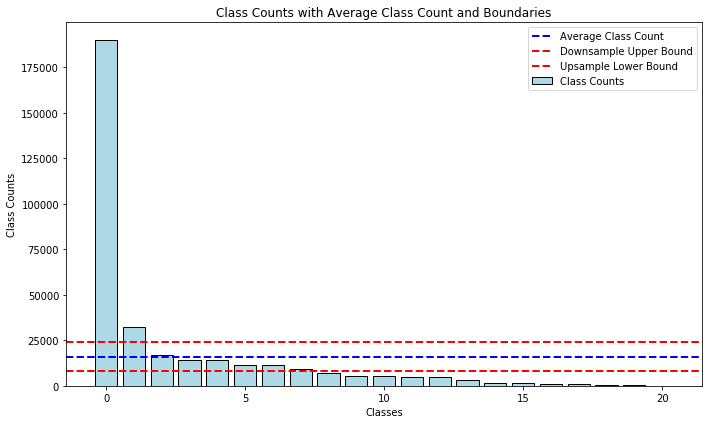

In [15]:
# Plot the class counts and boundaries
plt.figure(figsize=(10, 6))

# Plot class counts
plt.bar(class_counts['label'], class_counts['count'], color='lightblue', edgecolor='black', label='Class Counts')

# Plot the average class count line
plt.axhline(average_class_count, color='blue', linestyle='--', linewidth=2, label='Average Class Count')

# Plot the upper and lower bounds
plt.axhline(downsample_upper_bound, color='red', linestyle='--', linewidth=2, label='Downsample Upper Bound')
plt.axhline(upsample_lower_bound, color='red', linestyle='--', linewidth=2, label='Upsample Lower Bound')

# Add labels and title
plt.xlabel('Classes')
plt.ylabel('Class Counts')
plt.title('Class Counts with Average Class Count and Boundaries')
plt.legend()

# Show the plot
plt.tight_layout()
#plt.savefig('Class_Counts_Before_Sampling.png', dpi=300, bbox_inches='tight')
plt.show()

In [16]:
# Resampling via poisson random sampling
counts = {label: count for label, count in training.groupBy("label").count().collect()}
count_lower_bound = 8011
count_upper_bound = 24033

In [17]:
# Add a column with a random uniform distribution
training_with_random = training.withColumn("uniform_random", F.rand())

# Show the result
show_as_html(training_with_random)

,features,label,uniform_random
0,"[2.052, 3356.0, 27180.0, 39970000.0, 322300000...",6.0,0.273031
1,"[0.8095, 6713.0, 34010.0, 160600000.0, 8165000...",6.0,0.453443
2,"[1.041, 3368.0, 30310.0, 40200000.0, 350400000...",6.0,0.169434
3,"[1.796, 6721.0, 38900.0, 161100000.0, 93110000...",6.0,0.756000
4,"[1.548, 6716.0, 37010.0, 160800000.0, 87790000...",6.0,0.418959
5,"[0.6547, 3353.0, 7638.0, 39890000.0, 87100000....",6.0,0.449814
6,"[1.576, 6715.0, 42800.0, 160700000.0, 10280000...",6.0,0.912845
7,"[0.5521, 6711.0, 42260.0, 160500000.0, 1010000...",6.0,0.435742
8,"[1.472, 3356.0, 29120.0, 39980000.0, 346900000...",6.0,0.922432
9,"[0.5653, 3354.0, 23240.0, 39960000.0, 28480000...",6.0,0.500827


In [18]:
# Resampling via poisson random sampling
counts = {label: count for label, count in training.groupBy("label").count().collect()}
count_lower_bound = 8011
count_upper_bound = 24033

def random_resample(x, counts, count_lower_bound, count_upper_bound, random_value):
    count = counts[x]
    
    # Upsample if count is below the lower bound
    if count < count_lower_bound:
        return [x] * int(1 + np.random.poisson((count_lower_bound - count) / count))  # randomly upsample to count_lower_bound
    
    # Downsample if count is above the upper bound
    if count > count_upper_bound:
        probability = count_upper_bound / count
        if random_value < probability:
            return [x]  # Keep the sample
        else:
            return []  # Drop the sample

    return [x]  # Do nothing if within bounds

# Create UDF
random_resample_udf = F.udf(lambda x, rand_val: random_resample(x, counts, count_lower_bound, count_upper_bound, rand_val), ArrayType(IntegerType()))

# Apply the UDF for resampling
training_resampled = (
    training_with_random
    .withColumn("sample", random_resample_udf(F.col("label"), F.col("uniform_random")))
    .select(
        F.col("label"),
        F.col("features"),
        F.explode(F.col("sample")).alias("sample")
    )
    .drop("sample")
)

# Show class balance after resampling
show_class_balance(training_resampled, "training (resampled)")

Class balance [training (resampled)]

total:   229282
counts:
    label  count     ratio
0     6.0  11355  0.049524
1     7.0   9352  0.040788
2    12.0   8137  0.035489
3    13.0   7931  0.034591
4     1.0  24076  0.105006
5     4.0  14003  0.061073
6    17.0   8000  0.034892
7    20.0   8104  0.035345
8     8.0   8043  0.035079
9     9.0   7961  0.034721
10   14.0   8002  0.034900
11    0.0  24122  0.105207
12   10.0   8019  0.034974
13   18.0   7998  0.034883
14    3.0  14219  0.062015
15   16.0   7879  0.034364
16   19.0   8025  0.035001
17    2.0  16719  0.072919
18    5.0  11451  0.049943
19   11.0   7996  0.034874
20   15.0   8125  0.035437



In [19]:
show_as_html(training_resampled)

,label,features
0,6.0,"[2.052, 3356.0, 27180.0, 39970000.0, 322300000..."
1,6.0,"[0.8095, 6713.0, 34010.0, 160600000.0, 8165000..."
2,6.0,"[1.041, 3368.0, 30310.0, 40200000.0, 350400000..."
3,6.0,"[1.796, 6721.0, 38900.0, 161100000.0, 93110000..."
4,6.0,"[1.548, 6716.0, 37010.0, 160800000.0, 87790000..."
5,6.0,"[0.6547, 3353.0, 7638.0, 39890000.0, 87100000...."
6,6.0,"[1.576, 6715.0, 42800.0, 160700000.0, 10280000..."
7,6.0,"[0.5521, 6711.0, 42260.0, 160500000.0, 1010000..."
8,6.0,"[1.472, 3356.0, 29120.0, 39980000.0, 346900000..."
9,6.0,"[0.5653, 3354.0, 23240.0, 39960000.0, 28480000..."


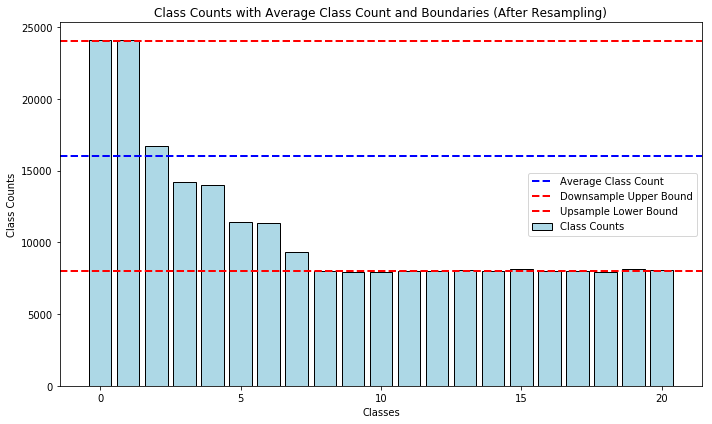

In [20]:
# Calculate the resampled class counts
resampled_class_counts = training_resampled.groupBy('label').count().toPandas()

# Calculate the new total rows and average class count after resampling
#new_total_rows = resampled_class_counts['count'].sum()
#new_average_class_count = new_total_rows / resampled_class_counts.shape[0]

# Define the new boundaries after resampling
#new_downsample_upper_bound = int(new_average_class_count * 1.5)
#new_upsample_lower_bound = int(new_average_class_count * 0.5)

# Plot the class counts after resampling
plt.figure(figsize=(10, 6))

# Plot resampled class counts
plt.bar(resampled_class_counts['label'], resampled_class_counts['count'], color='lightblue', edgecolor='black', label='Class Counts')

# Plot the average class count line
plt.axhline(average_class_count, color='blue', linestyle='--', linewidth=2, label='Average Class Count')

plt.axhline(downsample_upper_bound, color='red', linestyle='--', linewidth=2, label='Downsample Upper Bound')
plt.axhline(upsample_lower_bound, color='red', linestyle='--', linewidth=2, label='Upsample Lower Bound')

# Add labels and title
plt.xlabel('Classes')
plt.ylabel('Class Counts')
plt.title('Class Counts with Average Class Count and Boundaries (After Resampling)')
plt.legend()

# Show the plot
plt.tight_layout()
#plt.savefig('Class_Counts_After_Sampling.png', dpi=300, bbox_inches='tight')
plt.show()

#### Combine 2 plots Before Sampling and After Sampling

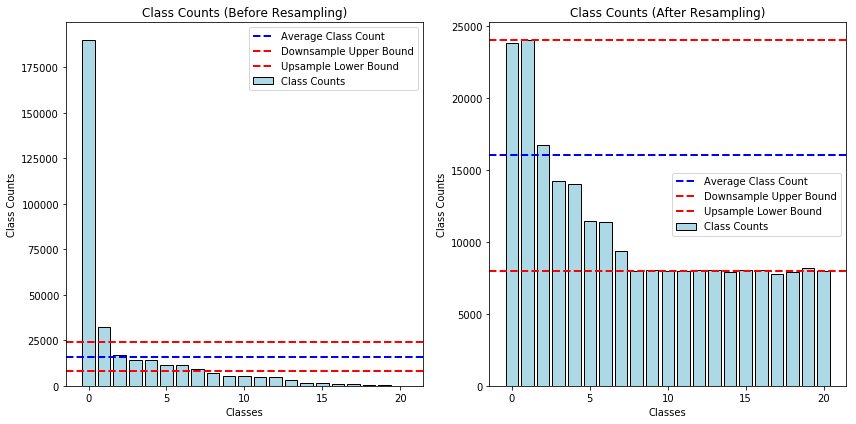

In [30]:

import matplotlib.pyplot as plt

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))  # 2 rows, 1 column

# Plot for Class Counts Before Resampling (on ax1)
ax1.bar(class_counts['label'], class_counts['count'], color='lightblue', edgecolor='black', label='Class Counts')
ax1.axhline(average_class_count, color='blue', linestyle='--', linewidth=2, label='Average Class Count')
ax1.axhline(downsample_upper_bound, color='red', linestyle='--', linewidth=2, label='Downsample Upper Bound')
ax1.axhline(upsample_lower_bound, color='red', linestyle='--', linewidth=2, label='Upsample Lower Bound')

ax1.set_xlabel('Classes')
ax1.set_ylabel('Class Counts')
ax1.set_title('Class Counts (Before Resampling)')
ax1.legend()

# Plot for Class Counts After Resampling (on ax2)
ax2.bar(resampled_class_counts['label'], resampled_class_counts['count'], color='lightblue', edgecolor='black', label='Class Counts')
ax2.axhline(average_class_count, color='blue', linestyle='--', linewidth=2, label='Average Class Count')
ax2.axhline(downsample_upper_bound, color='red', linestyle='--', linewidth=2, label='Downsample Upper Bound')
ax2.axhline(upsample_lower_bound, color='red', linestyle='--', linewidth=2, label='Upsample Lower Bound')

ax2.set_xlabel('Classes')
ax2.set_ylabel('Class Counts')
ax2.set_title('Class Counts (After Resampling)')
ax2.legend()

# Adjust layout and show both plots
plt.tight_layout()
#plt.savefig('Class_Before_After_Sampling.png', dpi=300, bbox_inches='tight')
plt.show()

### C.2 Perform Mutiple Classification Model 

In [21]:
# Define a function to evaluate and print metrics
def multiclass_metrics(predictions):
    
    # Initialize evaluator
    evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
    
    w_precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
    print(f"Weighted Precision: {w_precision}")
    
    w_recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
    print(f"Weighted Recall: {w_recall}")
    
    accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
    print(f"Accuracy: {accuracy}")

    f1 = evaluator.evaluate(predictions, {evaluator.metricName: "weightedFMeasure"})
    print(f"Weighted F1 Score: {f1}")

#### Classification Model without resampling 

In [22]:
# Training multiclass logistic regression without resampling

lr = LogisticRegression(featuresCol='features', labelCol='label', family="multinomial")
lr_model_multi = lr.fit(training)

# Make predictions on the test data
lr_pred_multi = lr_model_multi.transform(test)

multiclass_metrics(lr_pred_multi)

Weighted Precision: 0.3766537618332585
Weighted Recall: 0.564059287081169
Accuracy: 0.5640592870811691
Weighted F1 Score: 0.410048218811811


#### Classification Model with resampling 

In [22]:
# Training multiclass logistic regression with resampling

lr = LogisticRegression(featuresCol='features', labelCol='label',family="multinomial")
lr_model_multi_resampled = lr.fit(training_resampled)

# Make predictions on the test data
lr_pred_multi_resampled = lr_model_multi_resampled.transform(test)

multiclass_metrics(lr_pred_multi_resampled)

Weighted Precision: 0.4442948819619088
Weighted Recall: 0.36707356209810654
Accuracy: 0.36707356209810654
Weighted F1 Score: 0.3865464889589689


#### Classification Model without Resampling using OnevsRest

In [28]:
# Create the OneVsRest classifier
ovr = OneVsRest(classifier=lr)

# Train the One-vs-Rest model on the resampled data
ovr_model = ovr.fit(training)

# Make predictions on the test data
lr_pred_multi = ovr_model.transform(test)

# Evaluate predictions
multiclass_metrics(lr_pred_multi)

Weighted Precision: 0.3693343558445669
Weighted Recall: 0.5637977963462613
Accuracy: 0.5637977963462613
Weighted F1 Score: 0.4096521031752531


#### Classification Model with Resampling using OnevsRest

In [31]:
# Instantiate the binary logistic regression classifier
lr = LogisticRegression(featuresCol='features', labelCol='label')

# Create the OneVsRest classifier
ovr = OneVsRest(classifier=lr)

# Train the One-vs-Rest model on the resampled data
ovr_model = ovr.fit(training_resampled)

# Make predictions on the test data
lr_pred_multi_resampled = ovr_model.transform(test)

# Evaluate predictions
multiclass_metrics(lr_pred_multi_resampled)

Weighted Precision: 0.44716639067033875
Weighted Recall: 0.37717661321954526
Accuracy: 0.37717661321954526
Weighted F1 Score: 0.39430280788374816


### C.3 Precision and Recall per class metrics 

In [23]:
# Create a function to compute the precision and recall per class
def compute_per_class_metrics(predictions, label_col="label", prediction_col="prediction"):
    # Get all unique class labels
    class_labels = predictions.select(label_col).distinct().collect()

    # Loop through each class to compute precision and recall
    for label in class_labels:
        class_label = label[label_col]
        
        # Filter predictions for this class
        actual_class = predictions.filter(F.col(label_col) == class_label)
        predicted_class = predictions.filter(F.col(prediction_col) == class_label)
        
        # Calculate True Positive, False Positive, and False Negative
        TP = actual_class.filter(F.col(prediction_col) == F.col(label_col)).count()
        FN = actual_class.filter(F.col(prediction_col) != F.col(label_col)).count()
        FP = predicted_class.filter(F.col(prediction_col) != F.col(label_col)).count()
        
        # Handle division by zero cases
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        
        # Print precision and recall for the class
        print(f"Class {class_label}: Precision = {precision:.2f}, Recall = {recall:.2f}")

# Use the function to compute metrics for your One-vs-Rest model's predictions
compute_per_class_metrics(lr_pred_multi_resampled)

Class 6.0: Precision = 0.14, Recall = 0.00
Class 7.0: Precision = 0.00, Recall = 0.00
Class 12.0: Precision = 0.00, Recall = 0.00
Class 13.0: Precision = 0.09, Recall = 0.30
Class 1.0: Precision = 0.15, Recall = 0.38
Class 4.0: Precision = 0.03, Recall = 0.00
Class 17.0: Precision = 0.05, Recall = 0.03
Class 20.0: Precision = 0.00, Recall = 0.00
Class 8.0: Precision = 0.00, Recall = 0.00
Class 9.0: Precision = 0.00, Recall = 0.00
Class 14.0: Precision = 0.05, Recall = 0.48
Class 0.0: Precision = 0.72, Recall = 0.53
Class 10.0: Precision = 0.00, Recall = 0.00
Class 18.0: Precision = 0.01, Recall = 0.32
Class 3.0: Precision = 0.11, Recall = 0.18
Class 16.0: Precision = 0.00, Recall = 0.00
Class 19.0: Precision = 0.00, Recall = 0.00
Class 2.0: Precision = 0.13, Recall = 0.23
Class 5.0: Precision = 0.10, Recall = 0.09
Class 11.0: Precision = 0.05, Recall = 0.01
Class 15.0: Precision = 0.03, Recall = 0.15


#### Per Class Metrics Visualzation 

In [25]:
def compute_per_class_metrics(predictions, label_col="label", prediction_col="prediction"):
    # Get all unique class labels
    class_labels = predictions.select(label_col).distinct().collect()
    
    metrics = []
    
    # Loop through each class to compute precision and recall
    for label in class_labels:
        class_label = label[label_col]
        
        # Filter predictions for this class
        actual_class = predictions.filter(F.col(label_col) == class_label)
        predicted_class = predictions.filter(F.col(prediction_col) == class_label)
        
        # Calculate True Positive, False Positive, and False Negative
        TP = actual_class.filter(F.col(prediction_col) == F.col(label_col)).count()
        FN = actual_class.filter(F.col(prediction_col) != F.col(label_col)).count()
        FP = predicted_class.filter(F.col(prediction_col) != F.col(label_col)).count()
        
        # Handle division by zero cases
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        
        # Append the metrics for this class
        metrics.append((class_label, precision, recall))
    
    # Convert the metrics to a Pandas DataFrame for plotting
    metrics_df = pd.DataFrame(metrics, columns=["Class Label", "Precision", "Recall"])
    
    return metrics_df

# Compute metrics and convert to Pandas DataFrame
metrics_df = compute_per_class_metrics(lr_pred_multi_resampled)

In [26]:
metrics_df.head()

,Class Label,Precision,Recall
0,6.0,0.136364,0.001057
1,7.0,0.000000,0.000000
2,12.0,0.000000,0.000000
3,13.0,0.093308,0.304619
4,1.0,0.146298,0.384606


#### Plot the precision and recall per class 

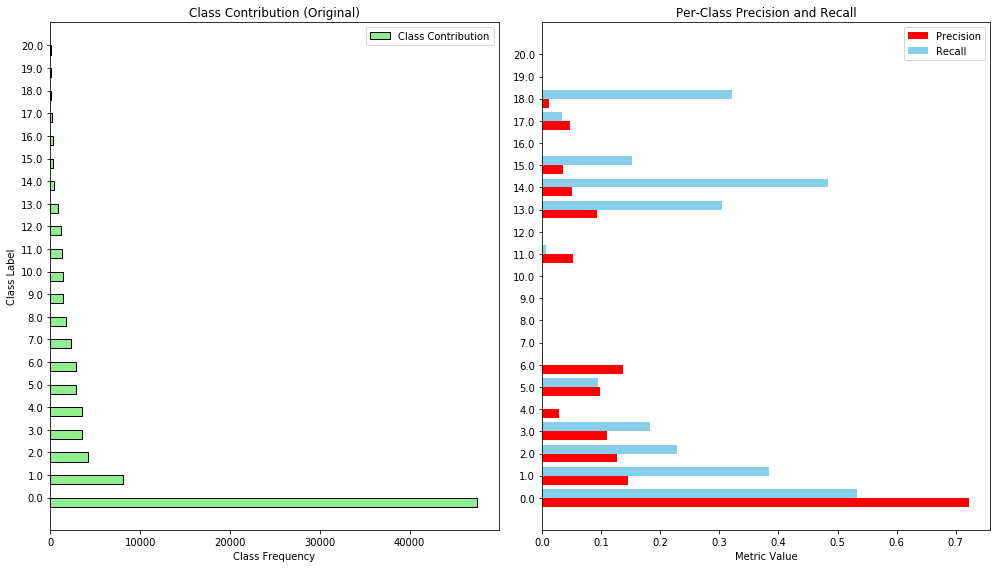

In [38]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Example: Assuming 'training_resampled' is a PySpark DataFrame and we calculate the class contribution
# Convert to pandas DataFrame
class_counts = test.groupBy("label").count().toPandas()

# Sort by label for consistency
test_class_counts = class_counts.sort_values(by='label')

# Sort by class label to align both datasets
metrics_df = metrics_df.sort_values(by='Class Label')

# Number of classes
class_labels = metrics_df['Class Label'].tolist()
precision = metrics_df['Precision'].tolist()
recall = metrics_df['Recall'].tolist()
class_contributions = test_class_counts['count'].tolist()

n_classes = len(class_labels)

# Create an index for the class labels
ind = np.arange(n_classes)

# Set the bar width
bar_width = 0.4

# Create subplots (1 row, 2 columns)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 8))

# Plot class contributions (frequency) on ax1
ax1.barh(ind, class_contributions, bar_width, color='lightgreen', edgecolor='black', label='Class Contribution')
ax1.set_xlabel('Class Frequency')
ax1.set_ylabel('Class Label')
ax1.set_title('Class Contribution (Original)')
ax1.set_yticks(ind + bar_width / 2)
ax1.set_yticklabels(class_labels)
ax1.legend()

# Plot precision and recall on ax2
precision_bars = ax2.barh(ind, precision, bar_width, color='red', label='Precision')
recall_bars = ax2.barh(ind + bar_width, recall, bar_width, color='skyblue', label='Recall')

ax2.set_xlabel('Metric Value')
ax2.set_title('Per-Class Precision and Recall')
ax2.set_yticks(ind + bar_width / 2)
ax2.set_yticklabels(class_labels)

# Add legend
ax2.legend()

# Show both plots
plt.tight_layout()
#plt.savefig('Per_Class_Metrics.png', dpi=300, bbox_inches='tight')
plt.show()

In [36]:
# Run this cell before closing the notebook or kill your spark application by hand using the link in the Spark UI

stop_spark()